## Section 0 - Imports

In [74]:
# %matplotlib qt
import numpy as np
import matplotlib.pyplot as plt
import cv2
import h5py
from scipy import ndimage
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.manifold import TSNE
from skimage.color import lab2rgb , rgb2lab
from skimage import feature
from skimage import filters

import scipy.fftpack
import scipy.signal as signal

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from sklearn.cluster import KMeans

import copy
import time

from openTSNE import TSNE as opTSNE

from sklearn.mixture import GaussianMixture 
from lifelines import KaplanMeierFitter
from scipy.stats import multivariate_normal
import imageio
from functools import reduce

'''
import matplotlib
import scipy
import sklearn
import skimage
import mpl_toolkits
import openTSNE
'''

'\nimport matplotlib\nimport scipy\nimport sklearn\nimport skimage\nimport mpl_toolkits\nimport openTSNE\n'

In [4]:
'''


print("numpy = " + np.__version__)
print("matplotlib = " + matplotlib.__version__)
print("h5py = " + h5py.__version__)
print("scipy = " + scipy.__version__)
print("pandas = " + pd.__version__)
print("sklearn = " + sklearn.__version__)
print("skimage = " + skimage.__version__)
print("seaborn = " + sns.__version__)
print("openTSNE = " + openTSNE.__version__)

'''

'\n\n\nprint("numpy = " + np.__version__)\nprint("matplotlib = " + matplotlib.__version__)\nprint("h5py = " + h5py.__version__)\nprint("scipy = " + scipy.__version__)\nprint("pandas = " + pd.__version__)\nprint("sklearn = " + sklearn.__version__)\nprint("skimage = " + skimage.__version__)\nprint("seaborn = " + sns.__version__)\nprint("openTSNE = " + openTSNE.__version__)\n\n'

## Section Utility Functions

In [5]:
def SampleZoomIn(SampleID , PixelSampleID ,padding_factor = 1):
    specific_index = SampleID
    mask = (PixelSampleID == specific_index) 
    label_indices = np.where(mask == True)

    zoomed_height_max = max(label_indices[0]) + padding_factor
    zoomed_height_min = min(label_indices[0]) - padding_factor
    zoomed_width_max = max(label_indices[1]) + padding_factor
    zoomed_width_min = min(label_indices[1]) - padding_factor

    if zoomed_height_max > height:
        zoomed_height_max= height

    if zoomed_height_min < 0:
        zoomed_height_min= 0

    if zoomed_width_max > width:
        zoomed_width_max= width

    if zoomed_width_min < 0:
        zoomed_width_min= 0
        
    return zoomed_height_max , zoomed_height_min , zoomed_width_max, zoomed_width_min



In [6]:
# Util function for convert-to (0 - 1) range
def rescale(arr):
    arr_min = arr.min()
    arr_max = arr.max()
    return (arr - arr_min) / (arr_max - arr_min)

def rescale_AB(arr):
    arr_min = arr.min()
    arr_max = arr.max()
    return ( (arr - arr_min) / (arr_max - arr_min)  ) * 255 - 128

In [7]:
def CreateColorMap(NumberofColors , colorsArray ):
    cvals = np.arange(0,NumberofColors-1)
    colors = colorsArray
    norm=plt.Normalize(min(cvals),max(cvals))
    tuples = list(zip(map(norm,cvals), colors))
    cmap = LinearSegmentedColormap.from_list("", tuples)
    return cmap

## Section 1 - Data Preparation

In [8]:
h5 = h5py.File('GastricData.mat', 'r')


# Get all data variables and store them

HE_image= h5.get('HE_image')[:]
HE_image = HE_image.swapaxes(0,2)


MSI_data_cube= h5.get('MSI_data_cube')[:]
MSI_data_cube = MSI_data_cube.swapaxes(0,2)

goodlist= h5.get('goodlist')[:]
goodlist = goodlist.swapaxes(0,1)

peak_list= h5.get('peak_list')[:]
peak_list = peak_list.swapaxes(0,1)

pixel_to_sample_ID= h5.get('pixel_to_sample_ID')[:]
pixel_to_sample_ID = pixel_to_sample_ID.swapaxes(0,1)  

h5.close()

# Clinical_data = pd.read_excel('ClinicalData.xlsx')

height , width = (pixel_to_sample_ID.shape) # ( 443 , 1653 )

flattened_MSI_data_cube = MSI_data_cube.flatten().reshape(MSI_data_cube.shape[0] * MSI_data_cube.shape[1] , MSI_data_cube.shape[2])

flattened_pixel_to_sample_ID = pixel_to_sample_ID.flatten() 
indices_of_background = np.where(flattened_pixel_to_sample_ID == -1)
sample_only_data = np.delete(flattened_MSI_data_cube, indices_of_background[0] , axis=0)
sample_ID_pixels = np.delete(flattened_pixel_to_sample_ID , indices_of_background[0] , axis=0)
# The scaler object (model)
scaler = StandardScaler()
# fit and transform the data
sample_only_scaled_data = scaler.fit_transform(sample_only_data) 

## Section 2 - PCA

In [9]:
pca = PCA(n_components=5)
pca_result = pca.fit_transform(sample_only_scaled_data)

pca_df = pd.DataFrame(data=pca_result[:],columns=["PC1","PC2","PC3","PC4","PC5"])
print('Explained variation per PC: {}'.format(pca.explained_variance_ratio_))
variance = pca.explained_variance_ratio_

Explained variation per PC: [0.18299616 0.09497918 0.06341938 0.04655058 0.0373234 ]


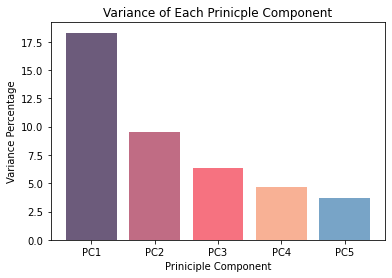

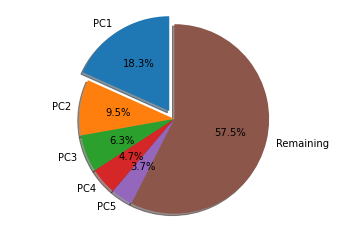

Variance Represented by PCA = 42.53 %


In [10]:
PCA=["PC1","PC2","PC3","PC4","PC5"]

COLORS = ["#6C5B7B","#C06C84","#F67280","#F8B195", "#78a4c7"]

plt.bar(PCA, variance*100, color=COLORS)

plt.title('Variance of Each Prinicple Component')
plt.xlabel('Priniciple Component')
plt.ylabel('Variance Percentage')

# Pie chart
labels = 'PC1', 'PC2', 'PC3', 'PC4' , 'PC5' , 'Remaining'
sizes = [ variance[0], variance[1], variance[2], variance[3] , variance[4] , 1 - ( variance[0] + variance[1] + variance[2] + variance[3] + variance[4] )  ]
explode = (0.1, 0, 0, 0, 0, 0) 

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, normalize=False)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()
print('Variance Represented by PCA = ' + str(round((variance[0] + variance[1] + variance[2] + variance[3] + variance[4])*100 , 2) ) +' %')

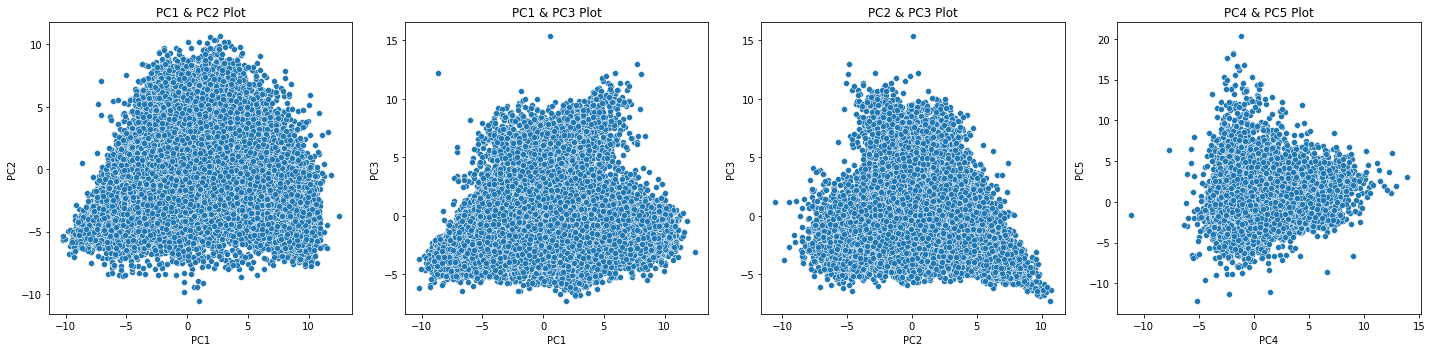

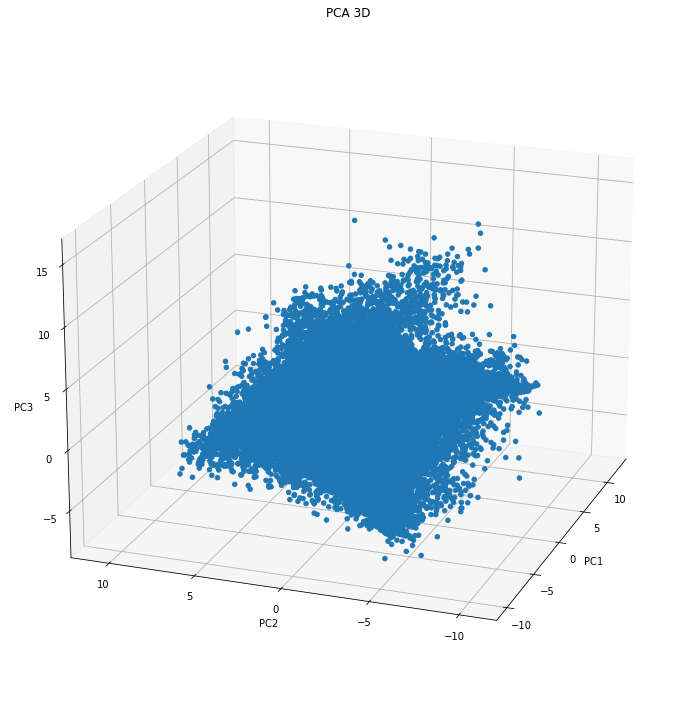

In [11]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
# sns.set(rc = {'figure.figsize':(15,8)})

sns.scatterplot(
    ax=axes[0],
    x="PC1", y="PC2",
    palette=sns.color_palette("icefire"),
    data=pca_df
)
axes[0].set_title("PC1 & PC2 Plot")

sns.scatterplot(
    ax=axes[1],
    x="PC1", y="PC3",
    palette=sns.color_palette("icefire"),
    data=pca_df
)
axes[1].set_title("PC1 & PC3 Plot")

sns.scatterplot(
    ax=axes[2],
    x="PC2", y="PC3",
    palette=sns.color_palette("icefire"),
    data=pca_df
)
axes[2].set_title("PC2 & PC3 Plot")

sns.scatterplot(
    ax=axes[3],
    x="PC4", y="PC5",
    palette=sns.color_palette("icefire"),
    data=pca_df
)
axes[3].set_title("PC4 & PC5 Plot")

plt.tight_layout()
plt.show()



ax = plt.figure(figsize=(16,10)).gca(projection='3d')
scatter_3d = ax.scatter(
    xs=pca_df['PC1'], 
    ys=pca_df['PC2'], 
    zs=pca_df['PC3'], 
    alpha = 1
)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title("PCA 3D")

fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

# elev is z-axis, +ve moves up, -ve moves down
# azim is x axis, +ve moves right, -ve moves left
ax.view_init(elev = 20 , azim = -160) 
plt.tight_layout()
plt.show()


## Section 3 - tSNE

In [12]:
# tSNE Model , Run once and save results in numpy array to be used later

'''
time_start = time.time()
tsne = opTSNE(
    n_components = 3,
    perplexity = 40,
    learning_rate = 'auto',
    early_exaggeration_iter = 50,
    early_exaggeration = 4,
    n_iter = 1000,
    initialization = 'random',
    initial_momentum = 0.5,
    final_momentum = 0.8,
    metric="euclidean",
    n_jobs=8,
    random_state=0,
    negative_gradient_method = 'barnes-hut',
    verbose=True,
)

%time tsne_results_op = tsne.fit(sample_only_scaled_data)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

np.save('op_tSNE_Results_' + 'Time_{}_seconds'.format(time.time()-time_start) , tsne_results)
'''

'\ntime_start = time.time()\ntsne = opTSNE(\n    n_components = 3,\n    perplexity = 40,\n    learning_rate = \'auto\',\n    early_exaggeration_iter = 50,\n    early_exaggeration = 4,\n    n_iter = 1000,\n    initialization = \'random\',\n    initial_momentum = 0.5,\n    final_momentum = 0.8,\n    metric="euclidean",\n    n_jobs=8,\n    random_state=0,\n    negative_gradient_method = \'barnes-hut\',\n    verbose=True,\n)\n\n%time tsne_results_op = tsne.fit(sample_only_scaled_data)\n\nprint(\'t-SNE done! Time elapsed: {} seconds\'.format(time.time()-time_start))\n\nnp.save(\'op_tSNE_Results_\' + \'Time_{}_seconds\'.format(time.time()-time_start) , tsne_results)\n'

In [13]:
# Load the t-SNE results
op_tsne_results = np.load('op_tSNE_Results_Time_456.8306334018707_seconds.npy')

In [14]:
# Creating tSNE Dataframe with L,A,B Components interpreted from tSNE Dimensions
tsne_df = pd.DataFrame(data=op_tsne_results[:],columns=["tSNE_dim1","tSNE_dim2","tSNE_dim3"])
tsne_df['pixel_ID'] = sample_ID_pixels
tsne_df['L_Component'] = op_tsne_results[:,0]
tsne_df['A_Component'] = op_tsne_results[:,1]
tsne_df['B_Component'] = op_tsne_results[:,2]

In [15]:
# Converting tSNE dimensions to be represented 

LAB_mapping = [ tsne_df['L_Component'] , tsne_df['A_Component'] , tsne_df['B_Component'] ]
LAB_colors = np.asarray(LAB_mapping)
LAB_colors = LAB_colors.swapaxes(0,1)

L = rescale(LAB_colors[:,0]) * 100
A = rescale_AB(LAB_colors[:,1])
B = rescale_AB(LAB_colors[:,2])
LAB_colors = np.asarray( [ L , A , B ] )
LAB_colors = LAB_colors.swapaxes(0,1)
RGB_colors = lab2rgb(LAB_colors)


C:\Users\dell\anaconda3\lib\site-packages\skimage\color\colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 1504 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


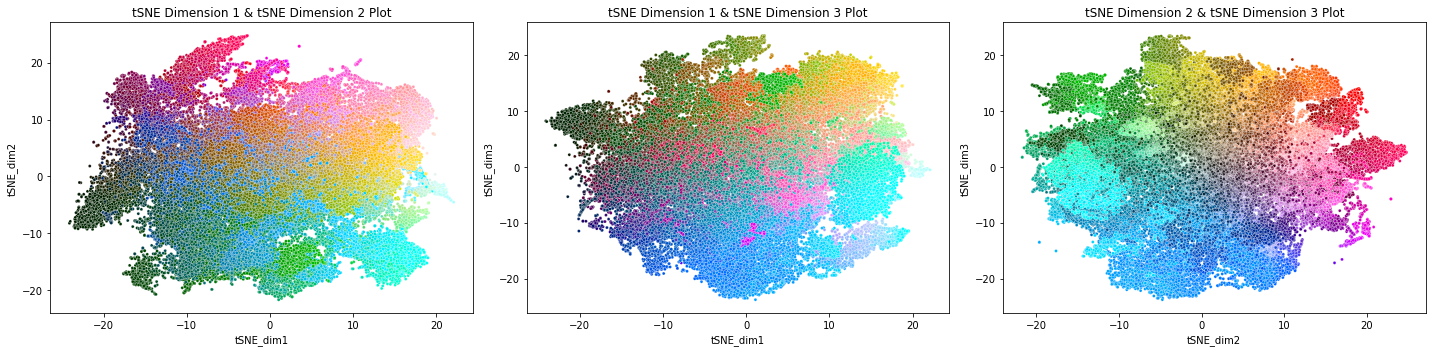

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
# sns.set(rc = {'figure.figsize':(15,8)})
marker_size = 9

sns.scatterplot(
    ax = axes[0],
    x = "tSNE_dim1", y="tSNE_dim2",
    c = RGB_colors,
    s = marker_size,
    data = tsne_df
)
axes[0].set_title("tSNE Dimension 1 & tSNE Dimension 2 Plot")

sns.scatterplot(
    ax = axes[1],
    x = "tSNE_dim1", y="tSNE_dim3",
    c = RGB_colors,
    s = marker_size,
    data = tsne_df
)
axes[1].set_title("tSNE Dimension 1 & tSNE Dimension 3 Plot")

sns.scatterplot(
    ax = axes[2],
    x = "tSNE_dim2", y="tSNE_dim3",
    c = RGB_colors,
    s = marker_size,
    data = tsne_df
)
axes[2].set_title("tSNE Dimension 2 & tSNE Dimension 3 Plot")



plt.tight_layout()
plt.show()



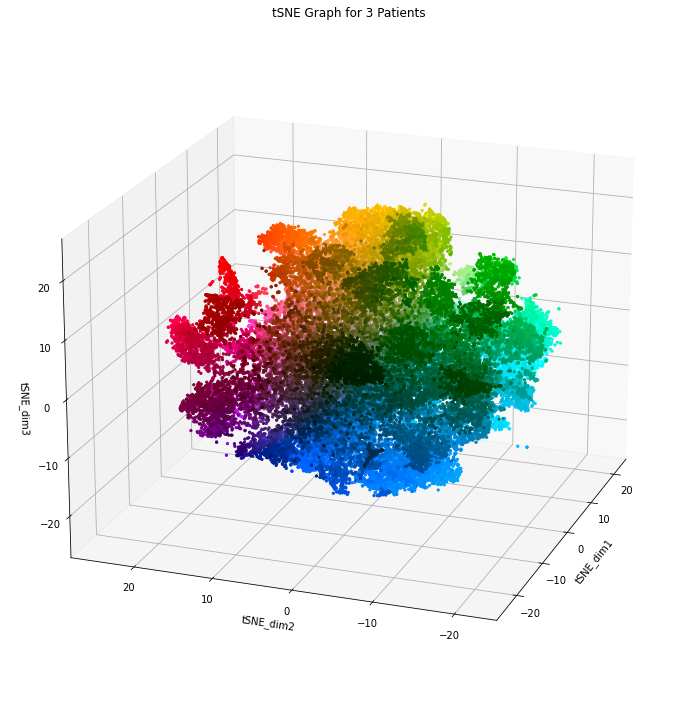

In [17]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
scatter_3d = ax.scatter(
    xs=tsne_df['tSNE_dim1'], 
    ys=tsne_df['tSNE_dim2'], 
    zs=tsne_df['tSNE_dim3'], 
    c = RGB_colors,
    s = 5,
    alpha = 1,
)

ax.set_xlabel('tSNE_dim1')
ax.set_ylabel('tSNE_dim2')
ax.set_zlabel('tSNE_dim3')
ax.set_title("tSNE Graph for 3 Patients")

# fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

# elev is z-axis, +ve moves up, -ve moves down
# azim is x axis, +ve moves right, -ve moves left
ax.view_init(elev = 20 , azim = -160) 
plt.tight_layout()


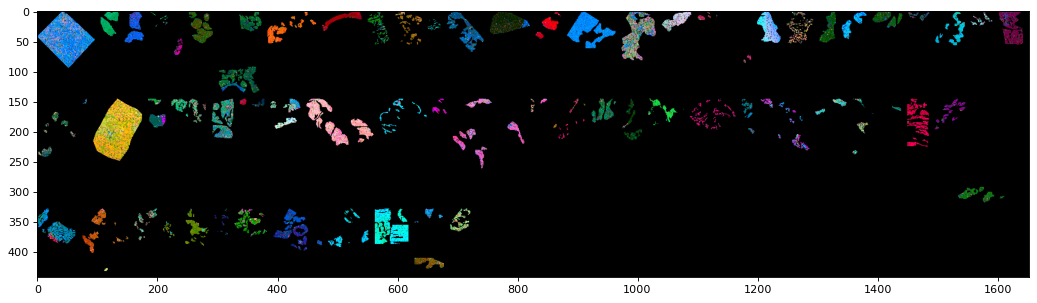

In [18]:
indices_edit = np.where(pixel_to_sample_ID != -1)
tsne_image = np.zeros( (height,width,3) )
increment = 0

for i,j in zip(indices_edit[0],indices_edit[1]):
    tsne_image[i][j][0] = RGB_colors[increment][0]
    tsne_image[i][j][1] = RGB_colors[increment][1]
    tsne_image[i][j][2] = RGB_colors[increment][2]
    increment += 1

plt.figure(figsize=(16, 8), dpi=80)
plt.imshow(tsne_image)


## Section 4 - Kmeans

In [19]:
############# Sklearn K-mean #################
kmeans_3 = KMeans(n_clusters=3, n_init=100, max_iter=2000, random_state=42, verbose=0 ).fit(op_tsne_results)
kmeans_4 = KMeans(n_clusters=4, n_init=100, max_iter=2000, random_state=42, verbose=0 ).fit(op_tsne_results)
kmeans_5 = KMeans(n_clusters=5, n_init=100, max_iter=2000, random_state=42, verbose=0 ).fit(op_tsne_results)


In [20]:
indices_edit = np.where(pixel_to_sample_ID != -1)
KMeans_image_3 = np.full( (height,width),-1 )
KMeans_image_4 = np.full( (height,width),-1 )
KMeans_image_5 = np.full( (height,width),-1 )
increment = 0
for i,j in zip(indices_edit[0],indices_edit[1]):
    KMeans_image_3[i][j] = kmeans_3.labels_[increment]
    KMeans_image_4[i][j] = kmeans_4.labels_[increment]
    KMeans_image_5[i][j] = kmeans_5.labels_[increment]

    increment += 1

In [21]:
# Defining Colors 
colorsarray = [ "black" , "#16235A" , "#F28A30", "#888C46" , "#EBF2EA" , "#0ABDA0" ] 
cmap = CreateColorMap(NumberofColors = 6 , colorsArray = colorsarray)

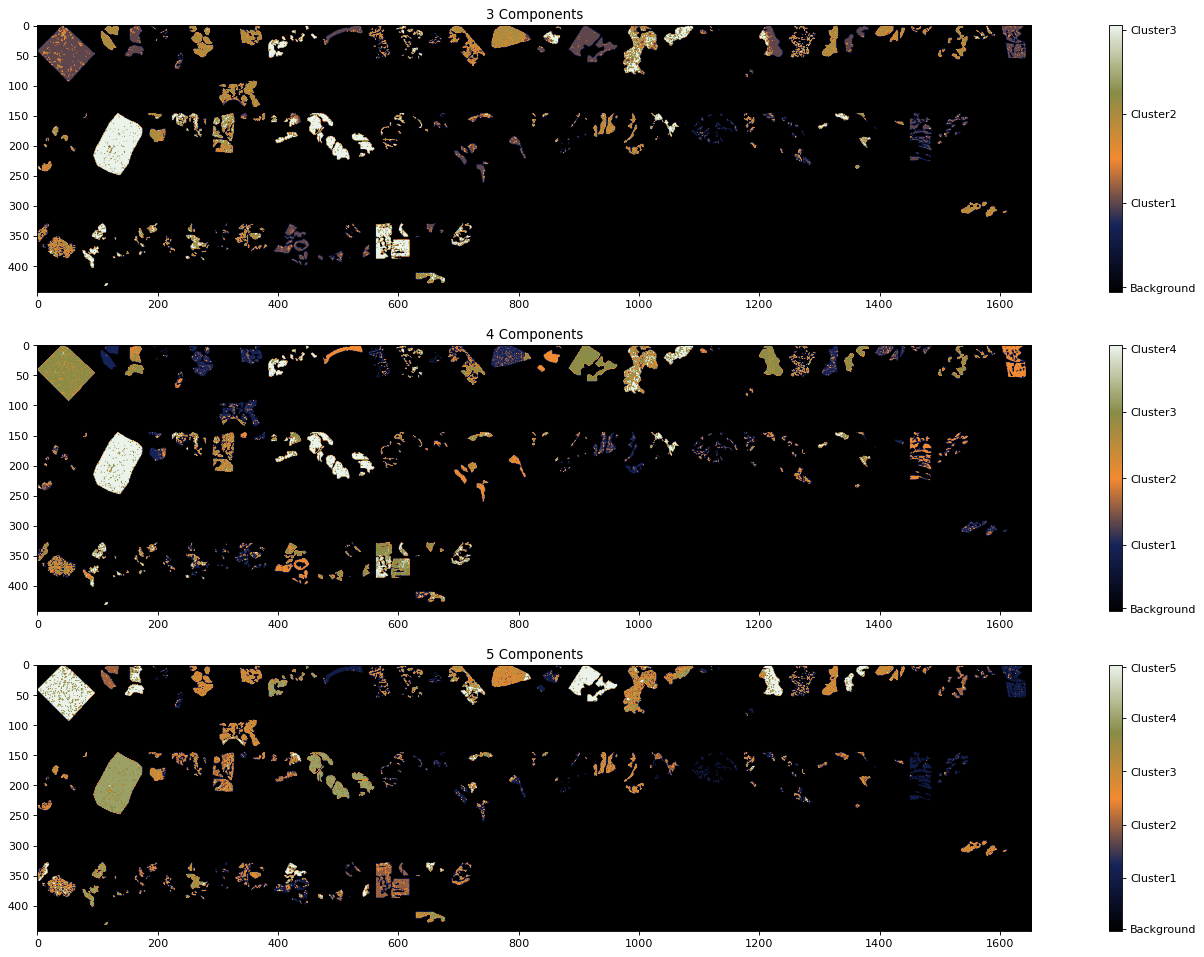

In [22]:
# Plotting Kmeans results

plt.figure(figsize=(25, 15), dpi=80)
plt.figure(1)
plt.subplot(311)
plt.title("3 Components")
plt.imshow(KMeans_image_3, cmap=cmap)
colorbar = plt.colorbar()
colorbar.set_ticks([-0.95 , 0 , 1, 1.95])
colorbar.set_ticklabels(["Background" , "Cluster1" , "Cluster2" , "Cluster3"])

plt.subplot(312)
plt.title("4 Components")
plt.imshow(KMeans_image_4, cmap=cmap)
colorbar = plt.colorbar()
colorbar.set_ticks([-0.95 , 0 , 1, 2,2.95])
colorbar.set_ticklabels(["Background" , "Cluster1" , "Cluster2" , "Cluster3" , "Cluster4"])


plt.subplot(313)
plt.title("5 Components")
plt.imshow(KMeans_image_5, cmap=cmap)
colorbar = plt.colorbar()
colorbar.set_ticks([-0.95 , 0 , 1, 2 , 3 , 3.95])
colorbar.set_ticklabels(["Background" , "Cluster1" , "Cluster2" , "Cluster3","Cluster4","Cluster5"])

plt.show()


In [23]:
# Getting Zoomedin Images

zoomed_height_max , zoomed_height_min , zoomed_width_max , zoomed_width_min = SampleZoomIn(
    SampleID = 13 , padding_factor = 0 , PixelSampleID = pixel_to_sample_ID)
zoomedIn_image_3 = KMeans_image_3[zoomed_height_min : zoomed_height_max+1, zoomed_width_min : zoomed_width_max+1]
zoomedIn_image_4 = KMeans_image_4[zoomed_height_min : zoomed_height_max+1, zoomed_width_min : zoomed_width_max+1]
zoomedIn_image_5 = KMeans_image_5[zoomed_height_min : zoomed_height_max+1, zoomed_width_min : zoomed_width_max+1]


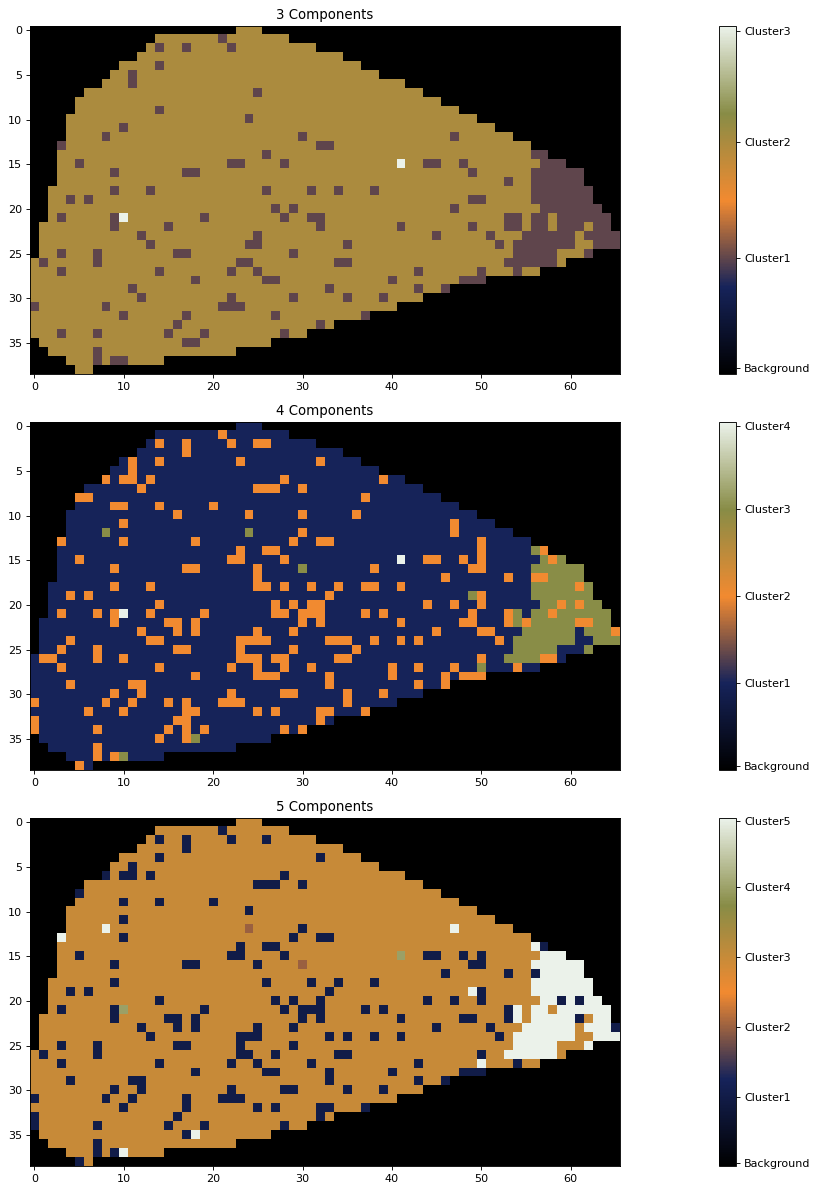

In [24]:
# Plotting Zoomedin results

plt.figure(figsize=(25, 15), dpi=80)
plt.figure(1)
plt.subplot(311)
plt.title("3 Components")
plt.imshow(zoomedIn_image_3, cmap=cmap)
colorbar = plt.colorbar()
colorbar.set_ticks([-0.95 , 0 , 1, 1.95])
colorbar.set_ticklabels(["Background" , "Cluster1" , "Cluster2" , "Cluster3"])

plt.subplot(312)
plt.title("4 Components")
plt.imshow(zoomedIn_image_4, cmap=cmap)
colorbar = plt.colorbar()
colorbar.set_ticks([-0.95 , 0 , 1, 2,2.95])
colorbar.set_ticklabels(["Background" , "Cluster1" , "Cluster2" , "Cluster3" , "Cluster4"])

plt.subplot(313)
plt.title("5 Components")
plt.imshow(zoomedIn_image_5, cmap=cmap)
colorbar = plt.colorbar()
colorbar.set_ticks([-0.95 , 0 , 1, 2 , 3 , 3.95])
colorbar.set_ticklabels(["Background" , "Cluster1" , "Cluster2" , "Cluster3","Cluster4","Cluster5"])
plt.tight_layout()
plt.show()

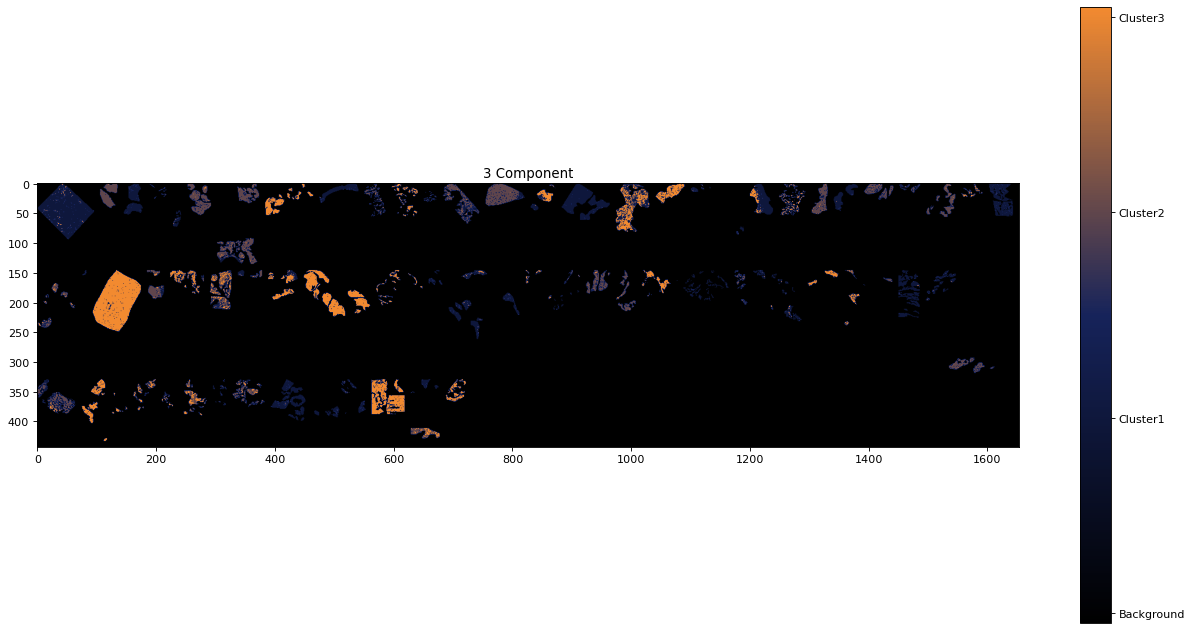

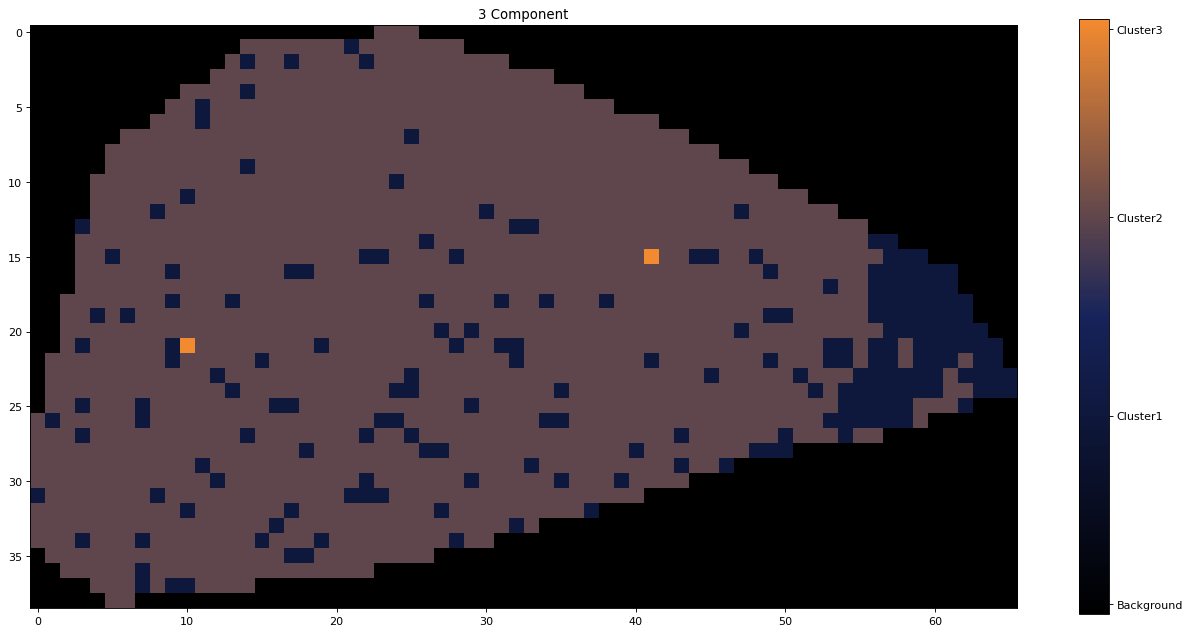

In [25]:
# 3 Components

colors = ["black","#16235A","#F28A30","#888C46"]
cmap = CreateColorMap(NumberofColors = 4 , colorsArray = colors )

plt.figure(figsize=(16, 8), dpi=80)
plt.title("3 Component")
plt.imshow(KMeans_image_3, cmap=cmap)

colorbar = plt.colorbar()
colorbar.set_ticks([-0.95 , 0 , 1, 1.95])
colorbar.set_ticklabels(["Background" , "Cluster1" , "Cluster2" , "Cluster3"])

plt.tight_layout()

# Zooming on sample id 13
SampleZoomIn(SampleID = 13 , PixelSampleID = pixel_to_sample_ID , padding_factor = 2)
kmeans_zoomedin_image = KMeans_image_3[zoomed_height_min : zoomed_height_max+1, zoomed_width_min : zoomed_width_max+1]

plt.figure(figsize=(16, 8), dpi=80)
plt.imshow(kmeans_zoomedin_image,cmap=cmap)
colorbar = plt.colorbar()
colorbar.set_ticks([-0.95 , 0 , 1, 1.95])
colorbar.set_ticklabels(["Background" , "Cluster1" , "Cluster2" , "Cluster3"])
plt.title("3 Component")
plt.tight_layout()


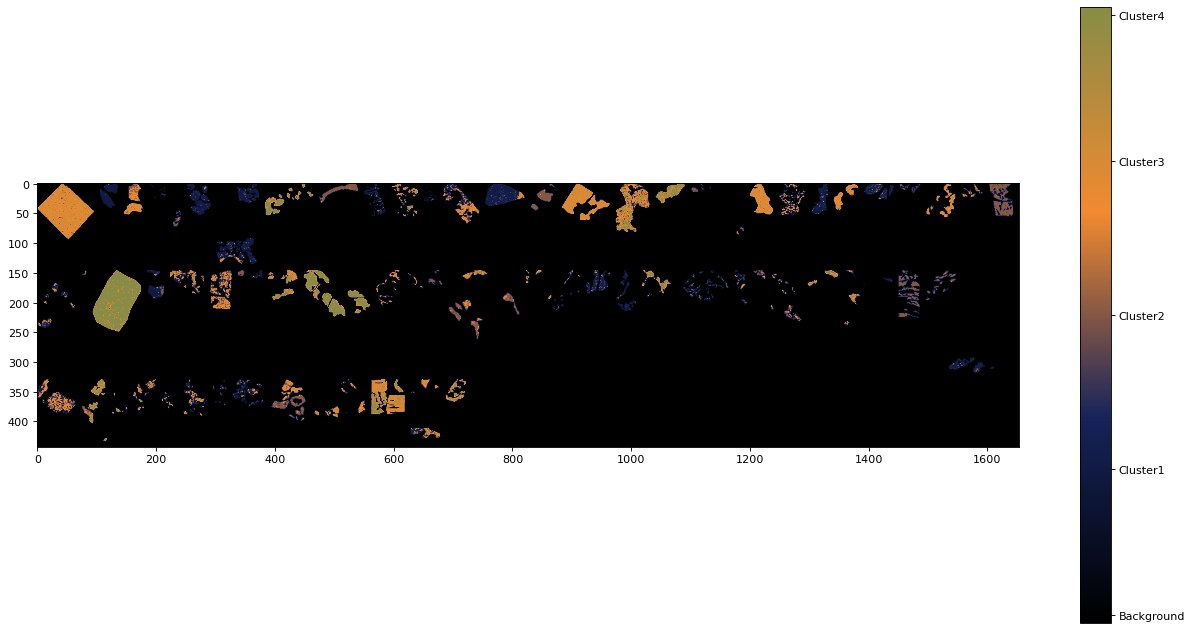

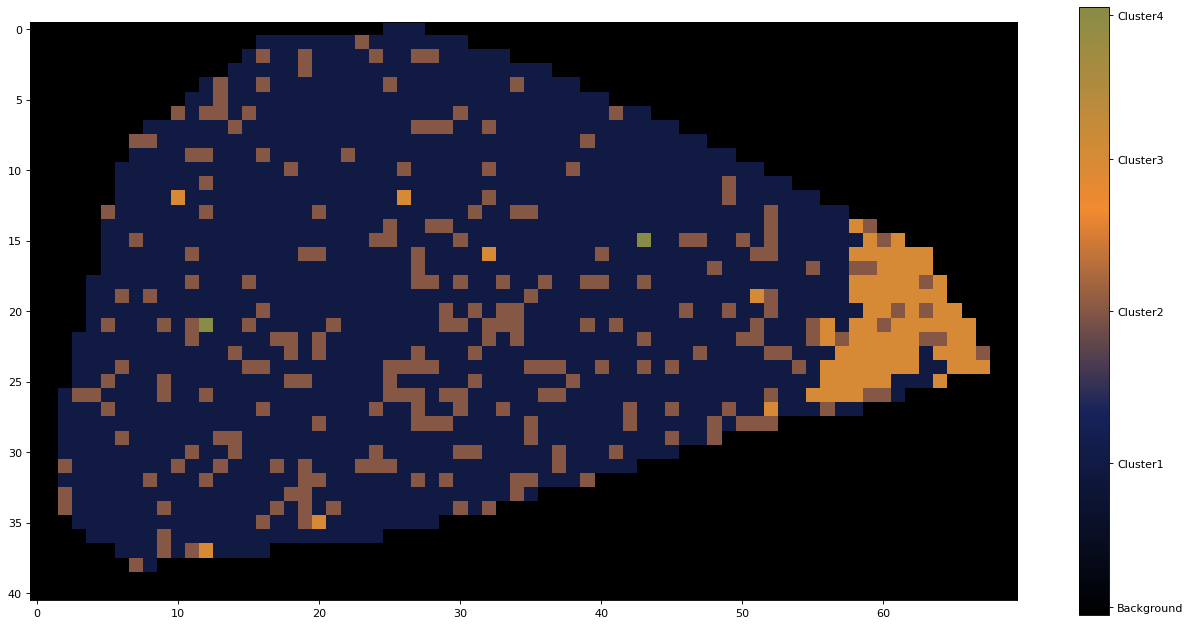

In [26]:
# 4 Components Bisecting Kmeans
# Coloring the K-means image with specific chosen colors)

colors = ["black","#16235A","#F28A30","#888C46", "#EBF2EA"]
cmap = CreateColorMap(NumberofColors = 5 , colorsArray = colors )

plt.figure(figsize=(16, 8), dpi=80)
plt.imshow(KMeans_image_4, cmap=cmap)

colorbar = plt.colorbar()
colorbar.set_ticks([-0.95 , 0 , 1, 2,2.95])
colorbar.set_ticklabels(["Background" , "Cluster1" , "Cluster2" , "Cluster3" , "Cluster4"])

plt.tight_layout()
# Zooming on sample id 13

zoomed_height_max , zoomed_height_min , zoomed_width_max , zoomed_width_min = SampleZoomIn(SampleID = 13 , PixelSampleID = pixel_to_sample_ID , padding_factor = 2)
kmeans_zoomedin_image = KMeans_image_4[zoomed_height_min : zoomed_height_max+1, zoomed_width_min : zoomed_width_max+1]

plt.figure(figsize=(16, 8), dpi=80)
plt.imshow(kmeans_zoomedin_image,cmap=cmap)
colorbar = plt.colorbar()
colorbar.set_ticks([-0.95 , 0 , 1, 2,2.95])
colorbar.set_ticklabels(["Background" , "Cluster1" , "Cluster2" , "Cluster3" , "Cluster4"])

plt.tight_layout()


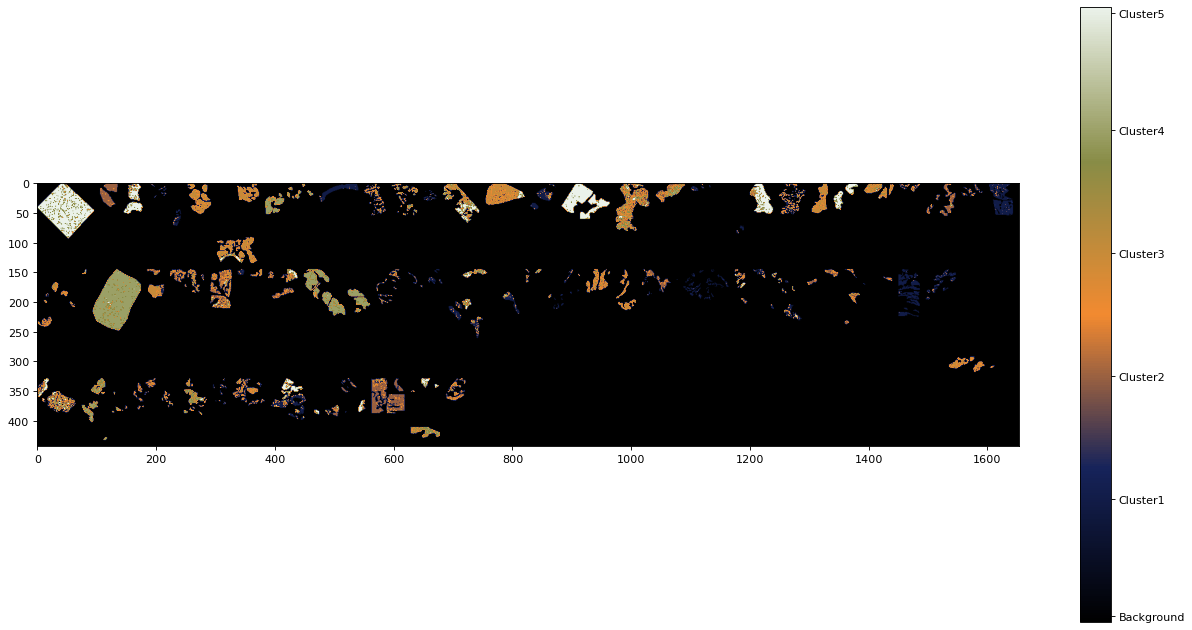

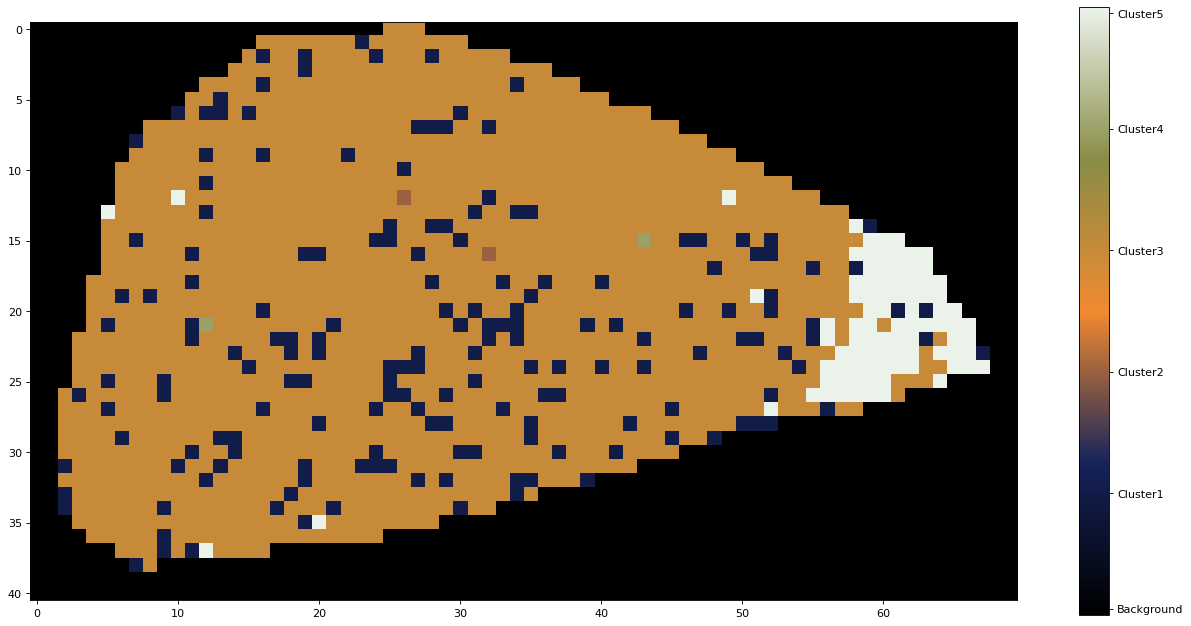

In [27]:
# 5 Components Kmeans

# Coloring the K-means image with specific chosen colors)

colors = ["black","#16235A","#F28A30","#888C46", "#EBF2EA","#0ABDA0"] #PURPLE, #DARK BLUE, #
cmap = CreateColorMap(NumberofColors = 6 , colorsArray = colors)


plt.figure(figsize=(16, 8), dpi=80)
plt.imshow(KMeans_image_5, cmap=cmap)

colorbar = plt.colorbar()
colorbar.set_ticks([-0.95 , 0 , 1, 2 , 3 , 3.95])
colorbar.set_ticklabels(["Background" , "Cluster1" , "Cluster2" , "Cluster3","Cluster4","Cluster5"])

plt.tight_layout()

# Zooming on sample id 13
zoomed_height_max , zoomed_height_min , zoomed_width_max , zoomed_width_min = SampleZoomIn(SampleID = 13 , PixelSampleID = pixel_to_sample_ID , padding_factor = 2)
kmeans_zoomedin_image = KMeans_image_5[zoomed_height_min : zoomed_height_max+1, zoomed_width_min : zoomed_width_max+1]

plt.figure(figsize=(16, 8), dpi=80)
plt.imshow(kmeans_zoomedin_image,cmap=cmap)
colorbar = plt.colorbar()
colorbar.set_ticks([-0.95 , 0 , 1, 2 , 3 , 3.95])
colorbar.set_ticklabels(["Background" , "Cluster1" , "Cluster2" , "Cluster3","Cluster4","Cluster5"])

plt.tight_layout()


## Section 5 - Bisecting Kmeans


In [28]:
# Manual Implementation of Bisecting KMeans , need to add reference

from sklearn.utils import shuffle

def initialCentroids(matrix):
    matrixShuffled = shuffle(matrix, random_state=0)
    return matrixShuffled[:2,:]

def similarity(matrix, centroids):
    similarities = matrix.dot(centroids.T)
    return similarities
def findClusters(matrix, centroids):
    
    clusterA = list()
    clusterB = list()
    
    similarityMatrix = similarity(matrix, centroids)
    
    for index in range(similarityMatrix.shape[0]):
        similarityRow = similarityMatrix[index]
        
        #Sort the index of the matrix in ascending order of value and get the index of the last element
        #This index will be the cluster that the row in input matrix will belong to
        similaritySorted = np.argsort(similarityRow)[-1]
        if similaritySorted == 0:
            clusterA.append(index)
        else:
            clusterB.append(index)
        
    return clusterA, clusterB

def recalculateCentroid(matrix, clusters):
    centroids = list()
    
    for i in range(0,2):
        cluster = matrix[clusters[i],:]
        clusterMean = cluster.mean(0)
        centroids.append(clusterMean)
        
    centroids_array = np.asarray(centroids)
    
    return centroids_array

def calculateSSE(matrix, clusters):
    
    SSE_list = list()
    SSE_array = []
    
    for cluster in clusters:
        members = matrix[cluster,:]
        SSE = np.sum(np.square(members - np.mean(members)))
        SSE_list.append(SSE)
        
    SSE_array = np.asarray(SSE_list)
    dropClusterIndex = np.argsort(SSE_array)[-1]
            
    return dropClusterIndex

def kmeans(matrix, numberOfIterations):
    
    centroids = initialCentroids(matrix)
    
    for _ in range(numberOfIterations):
        
        clusters = list()
        
        clusterA, clusterB = findClusters(matrix, centroids)
        
        if len(clusterA) > 1:
            clusters.append(clusterA)
        if len(clusterB) > 1:
            clusters.append(clusterB)
            
        centroids = recalculateCentroid(matrix, clusters)
        
    return clusterA, clusterB



def bisecting_kmeans(matrix, k, numberOfIterations):
    
    clusters = list()
    
    initialcluster = list()
    for i in range(matrix.shape[0]):
        initialcluster.append(i)
    
    clusters.append(initialcluster)
    
    while len(clusters) < k:

        dropClusterIndex = calculateSSE(matrix, clusters)
        droppedCluster = clusters[dropClusterIndex]
        
        clusterA, clusterB = kmeans(matrix[droppedCluster,:], numberOfIterations)
        del clusters[dropClusterIndex]
        
        actualClusterA = list()
        actualClusterB = list()
        for index in clusterA:
            actualClusterA.append(droppedCluster[index])
            
        for index in clusterB:
            actualClusterB.append(droppedCluster[index])
        
        clusters.append(actualClusterA)
        clusters.append(actualClusterB)
    
    labels = [0] * matrix.shape[0]

    for index, cluster in enumerate(clusters):
        for idx in cluster:
            labels[idx] = index + 1
    return labels

In [29]:
# Applying Bisecting KMeans

bisecting_kmeans_labels_3 = np.array(bisecting_kmeans(op_tsne_results , 3, 10) ) - 1
bisecting_kmeans_labels_4 = np.array(bisecting_kmeans(op_tsne_results , 4, 10) ) - 1
bisecting_kmeans_labels_5 = np.array(bisecting_kmeans(op_tsne_results , 5, 10) ) - 1

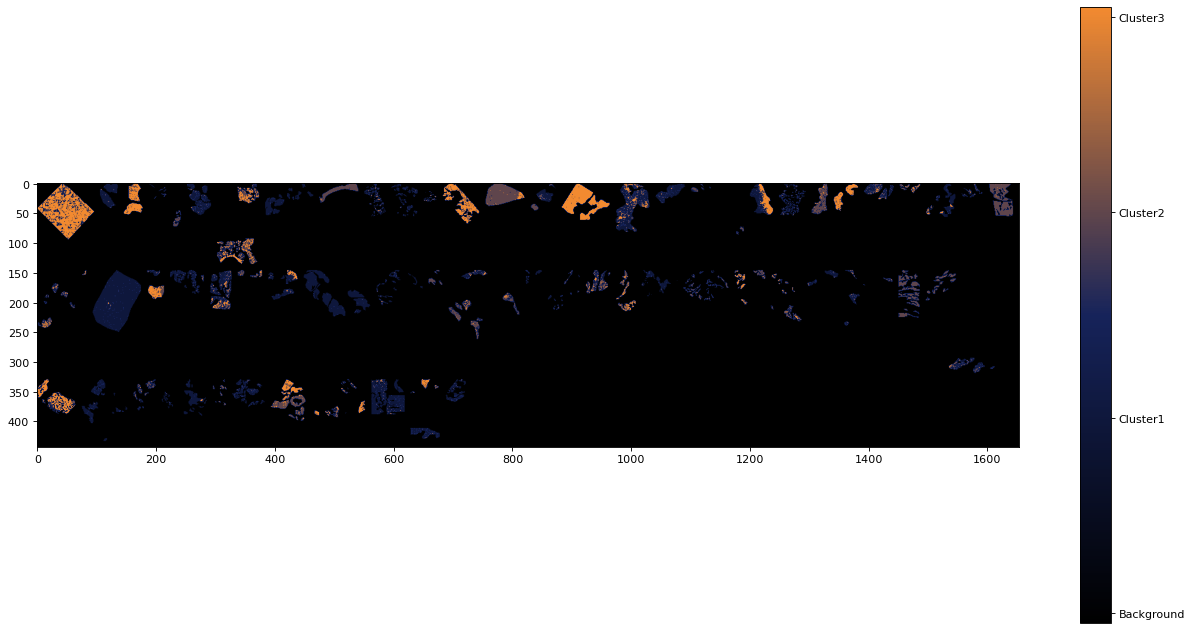

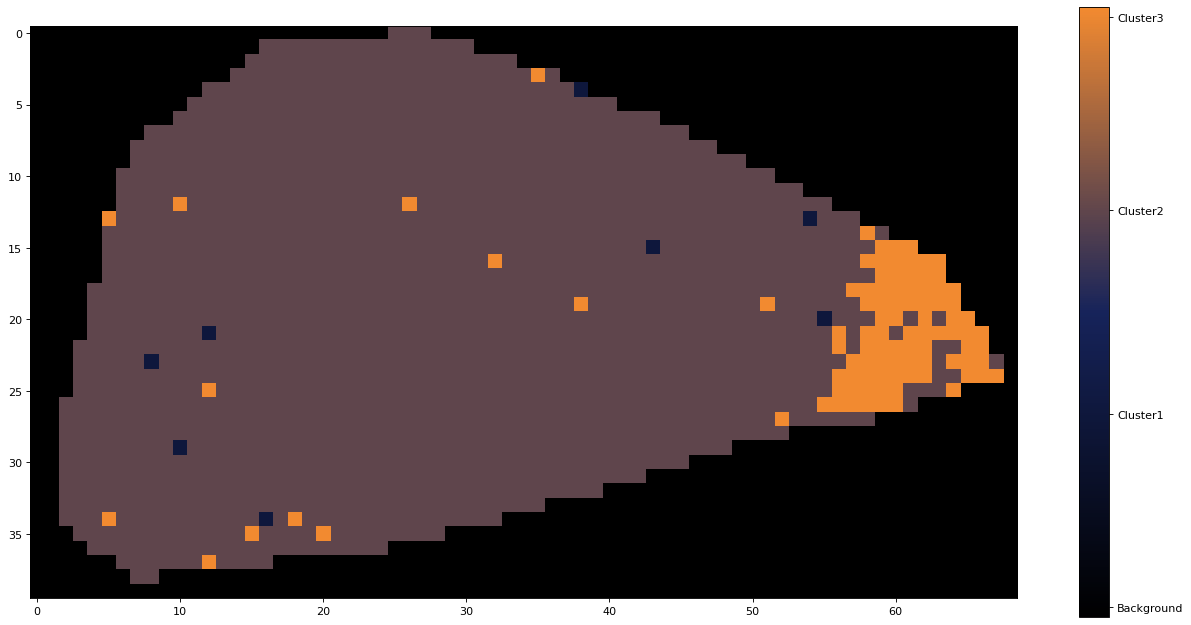

In [30]:
# 3 Components Bisecting Kmeans

indices_edit = np.where(pixel_to_sample_ID != -1)
bisecting_kmeans_image = np.full( (height,width),-1 )
increment = 0
for i,j in zip(indices_edit[0],indices_edit[1]):
    bisecting_kmeans_image[i][j] = bisecting_kmeans_labels_3[increment]
    increment += 1

# Coloring the K-means image with specific chosen colors)
colors = ["black","#16235A","#F28A30","#888C46"]
cmap = CreateColorMap(NumberofColors = 4 , colorsArray = colors)

plt.figure(figsize=(16, 8), dpi=80)
plt.imshow(bisecting_kmeans_image, cmap=cmap)

colorbar = plt.colorbar()
colorbar.set_ticks([-0.95 , 0 , 1, 1.95])
colorbar.set_ticklabels(["Background" , "Cluster1" , "Cluster2" , "Cluster3"])

plt.tight_layout()
# Zooming on sample id 13

zoomed_height_max , zoomed_height_min , zoomed_width_max , zoomed_width_min = SampleZoomIn(SampleID = 13 , PixelSampleID = pixel_to_sample_ID , padding_factor = 2)
bisectingkmeans_zoomedIn_image = bisecting_kmeans_image[zoomed_height_min : zoomed_height_max, zoomed_width_min : zoomed_width_max]

plt.figure(figsize=(16, 8), dpi=80)
plt.imshow(bisectingkmeans_zoomedIn_image,cmap=cmap)
colorbar = plt.colorbar()
colorbar.set_ticks([-0.95 , 0 , 1, 1.95])
colorbar.set_ticklabels(["Background" , "Cluster1" , "Cluster2" , "Cluster3"])

plt.tight_layout()


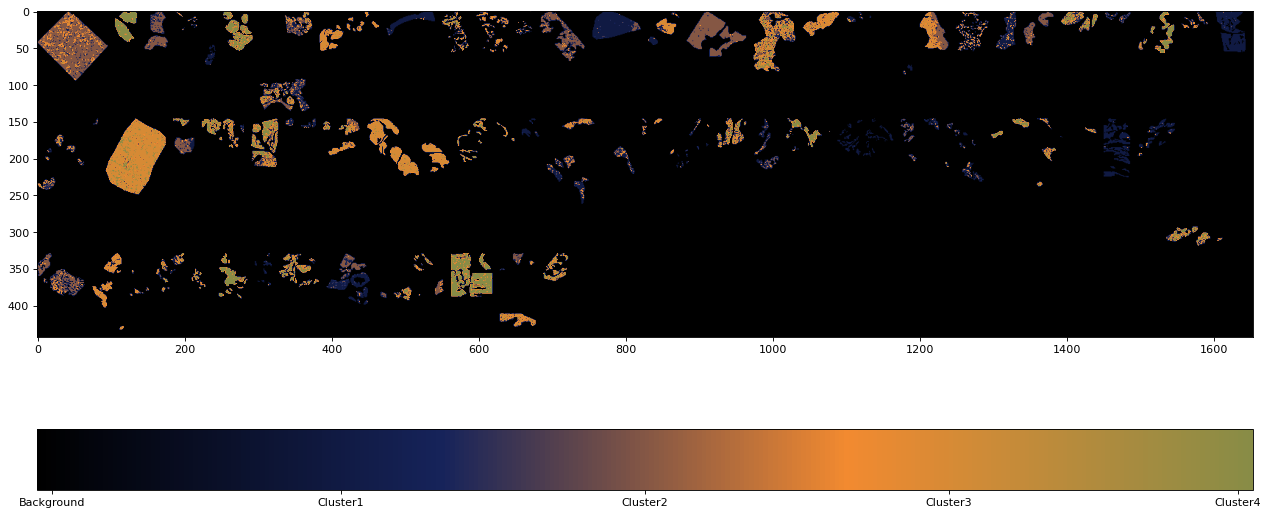

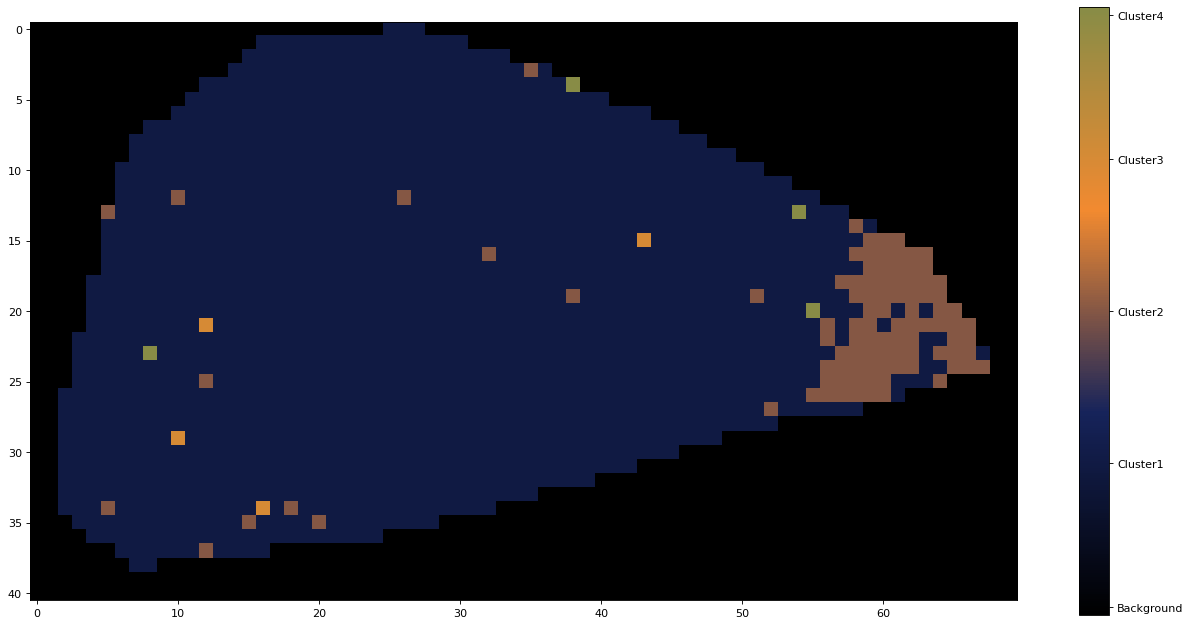

In [31]:
# 4 Components Bisecting Kmeans

indices_edit = np.where(pixel_to_sample_ID != -1)
bisecting_kmeans_image = np.full( (height,width),-1 )
increment = 0
for i,j in zip(indices_edit[0],indices_edit[1]):
    bisecting_kmeans_image[i][j] = bisecting_kmeans_labels_4[increment]
    increment += 1

# Coloring the K-means image with specific chosen colors)

colors = ["black","#16235A","#F28A30","#888C46", "#EBF2EA"]
cmap = CreateColorMap(NumberofColors = 5 , colorsArray = colors)

plt.figure(figsize=(16, 8), dpi=80)
plt.imshow(bisecting_kmeans_image, cmap=cmap)

colorbar = plt.colorbar(orientation = "horizontal")
colorbar.set_ticks([-0.95 , 0 , 1, 2,2.95])
colorbar.set_ticklabels(["Background" , "Cluster1" , "Cluster2" , "Cluster3" , "Cluster4"])

plt.tight_layout()
# Zooming on sample id 13

specific_index = 13
mask = (pixel_to_sample_ID == specific_index) 
kmeans_labels_indicies = np.where(mask == True)

zoomed_height_max , zoomed_height_min , zoomed_width_max , zoomed_width_min = SampleZoomIn(SampleID = 13 , PixelSampleID = pixel_to_sample_ID , padding_factor = 2)
bisectingkmeans_zoomedIn_image = bisecting_kmeans_image[zoomed_height_min : zoomed_height_max+1, zoomed_width_min : zoomed_width_max+1]

plt.figure(figsize=(16, 8), dpi=80)
plt.imshow(bisectingkmeans_zoomedIn_image,cmap=cmap)
colorbar = plt.colorbar()
colorbar.set_ticks([-0.95 , 0 , 1, 2,2.95])
colorbar.set_ticklabels(["Background" , "Cluster1" , "Cluster2" , "Cluster3" , "Cluster4"])

plt.tight_layout()


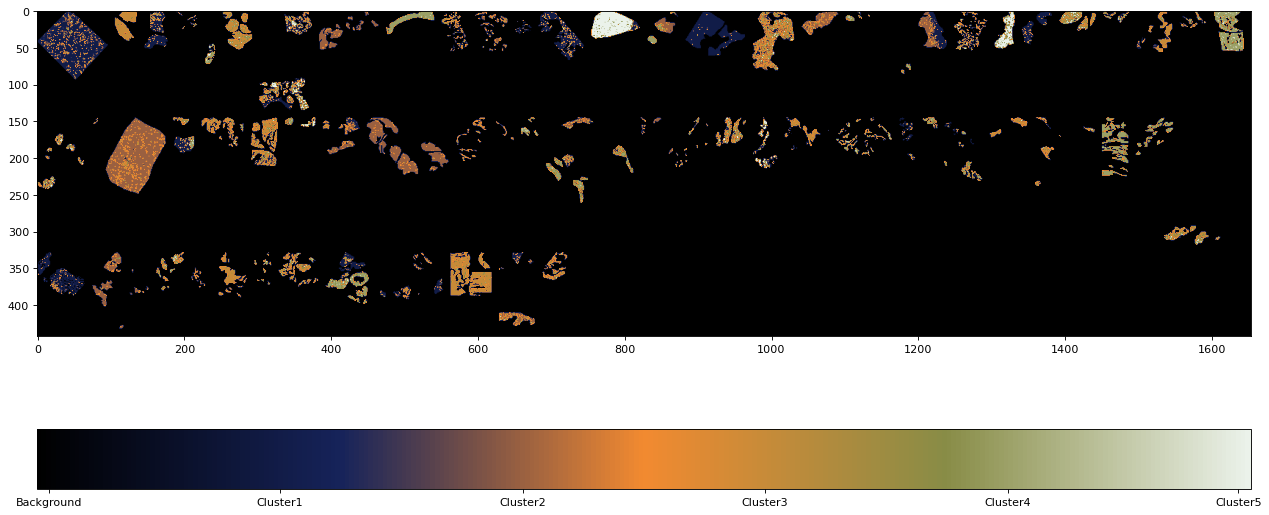

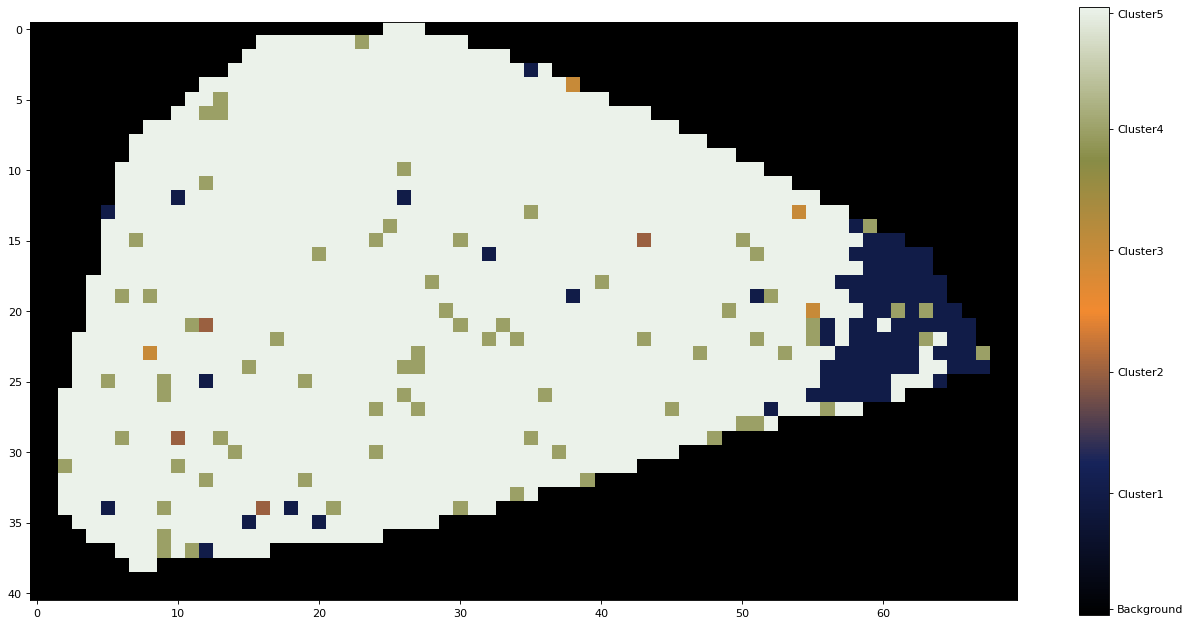

In [32]:
# 5 Components Bisecting Kmeans

indices_edit = np.where(pixel_to_sample_ID != -1)
bisecting_kmeans_image = np.full( (height,width),-1 )
increment = 0
for i,j in zip(indices_edit[0],indices_edit[1]):
    bisecting_kmeans_image[i][j] = bisecting_kmeans_labels_5[increment]
    increment += 1

# Coloring the K-means image with specific chosen colors)


colors = ["black","#16235A","#F28A30","#888C46", "#EBF2EA","#0ABDA0"] #PURPLE, #DARK BLUE, #
cmap = CreateColorMap(NumberofColors = 6 , colorsArray = colors)

plt.figure(figsize=(16, 8), dpi=80)
plt.imshow(bisecting_kmeans_image, cmap=cmap)

colorbar = plt.colorbar(orientation = "horizontal")
colorbar.set_ticks([-0.95 , 0 , 1, 2 , 3 , 3.95])
colorbar.set_ticklabels(["Background" , "Cluster1" , "Cluster2" , "Cluster3","Cluster4","Cluster5"])

plt.tight_layout()
# Zooming on sample id 13

zoomed_height_max , zoomed_height_min , zoomed_width_max , zoomed_width_min = SampleZoomIn(SampleID = 13 , PixelSampleID = pixel_to_sample_ID , padding_factor = 2)
bisectingkmeans_zoomedIn_image = bisecting_kmeans_image[zoomed_height_min : zoomed_height_max+1, zoomed_width_min : zoomed_width_max+1]

plt.figure(figsize=(16, 8), dpi=80)
plt.imshow(bisectingkmeans_zoomedIn_image,cmap=cmap)
colorbar = plt.colorbar()
colorbar.set_ticks([-0.95 , 0 , 1, 2 , 3 , 3.95])
colorbar.set_ticklabels(["Background" , "Cluster1" , "Cluster2" , "Cluster3","Cluster4","Cluster5"])

plt.tight_layout()


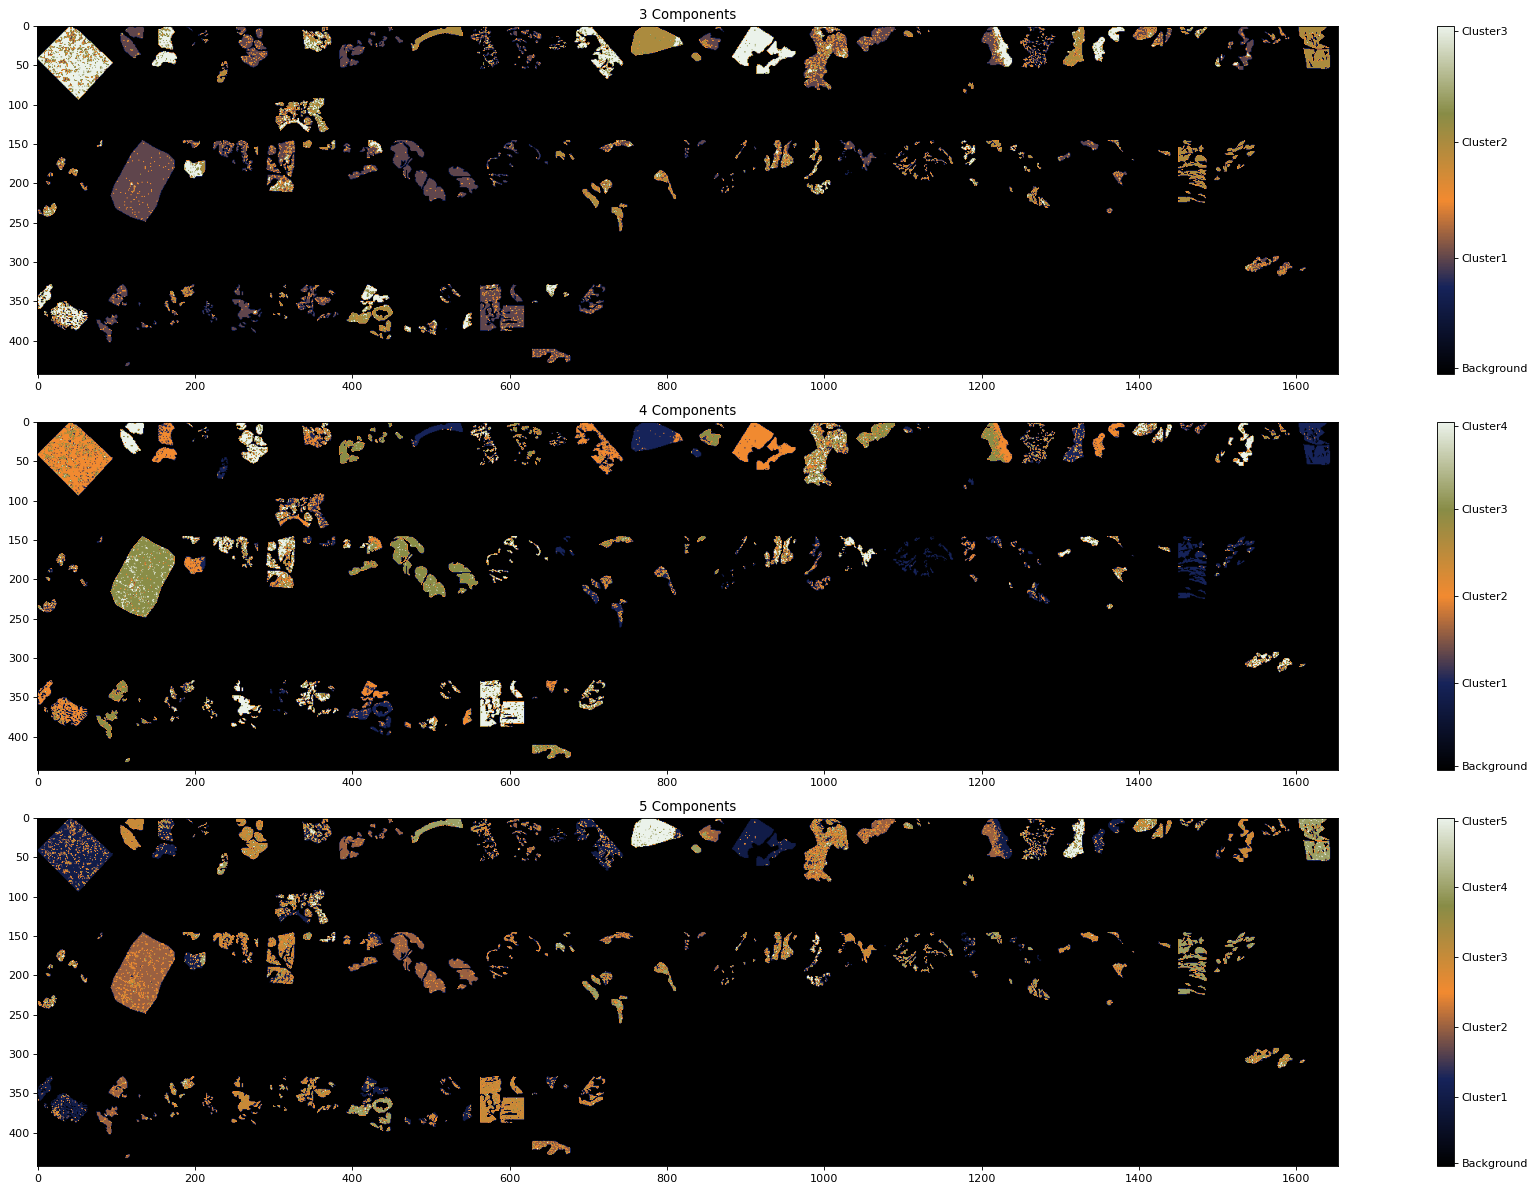

In [33]:
indices_edit = np.where(pixel_to_sample_ID != -1)
bisecting_kmeans_image_3 = np.full( (height,width),-1 )
bisecting_kmeans_image_4 = np.full( (height,width),-1 )
bisecting_kmeans_image_5 = np.full( (height,width),-1 )
increment = 0

for i,j in zip(indices_edit[0],indices_edit[1]):
    bisecting_kmeans_image_3[i][j] = bisecting_kmeans_labels_3[increment]
    bisecting_kmeans_image_4[i][j] = bisecting_kmeans_labels_4[increment]
    bisecting_kmeans_image_5[i][j] = bisecting_kmeans_labels_5[increment]

    increment += 1

colors = ["black","#16235A","#F28A30","#888C46", "#EBF2EA","#0ABDA0"] #PURPLE, #DARK BLUE, #
cmap = CreateColorMap(NumberofColors = 6 , colorsArray = colors)

plt.figure(figsize=(25, 15), dpi=80)
plt.figure(1)
plt.subplot(311)
plt.imshow(bisecting_kmeans_image_3, cmap=cmap)
plt.title("3 Components")
colorbar = plt.colorbar()
colorbar.set_ticks([-0.95 , 0 , 1, 1.95])
colorbar.set_ticklabels(["Background" , "Cluster1" , "Cluster2" , "Cluster3"])

plt.subplot(312)
plt.imshow(bisecting_kmeans_image_4, cmap=cmap)
colorbar = plt.colorbar()
plt.title("4 Components")
colorbar.set_ticks([-0.95 , 0 , 1, 2,2.95])
colorbar.set_ticklabels(["Background" , "Cluster1" , "Cluster2" , "Cluster3" , "Cluster4"])

plt.subplot(313)
plt.imshow(bisecting_kmeans_image_5, cmap=cmap)
colorbar = plt.colorbar()
plt.title("5 Components")
colorbar.set_ticks([-0.95 , 0 , 1, 2 , 3 , 3.95])
colorbar.set_ticklabels(["Background" , "Cluster1" , "Cluster2" , "Cluster3","Cluster4","Cluster5"])

plt.tight_layout()
plt.show()


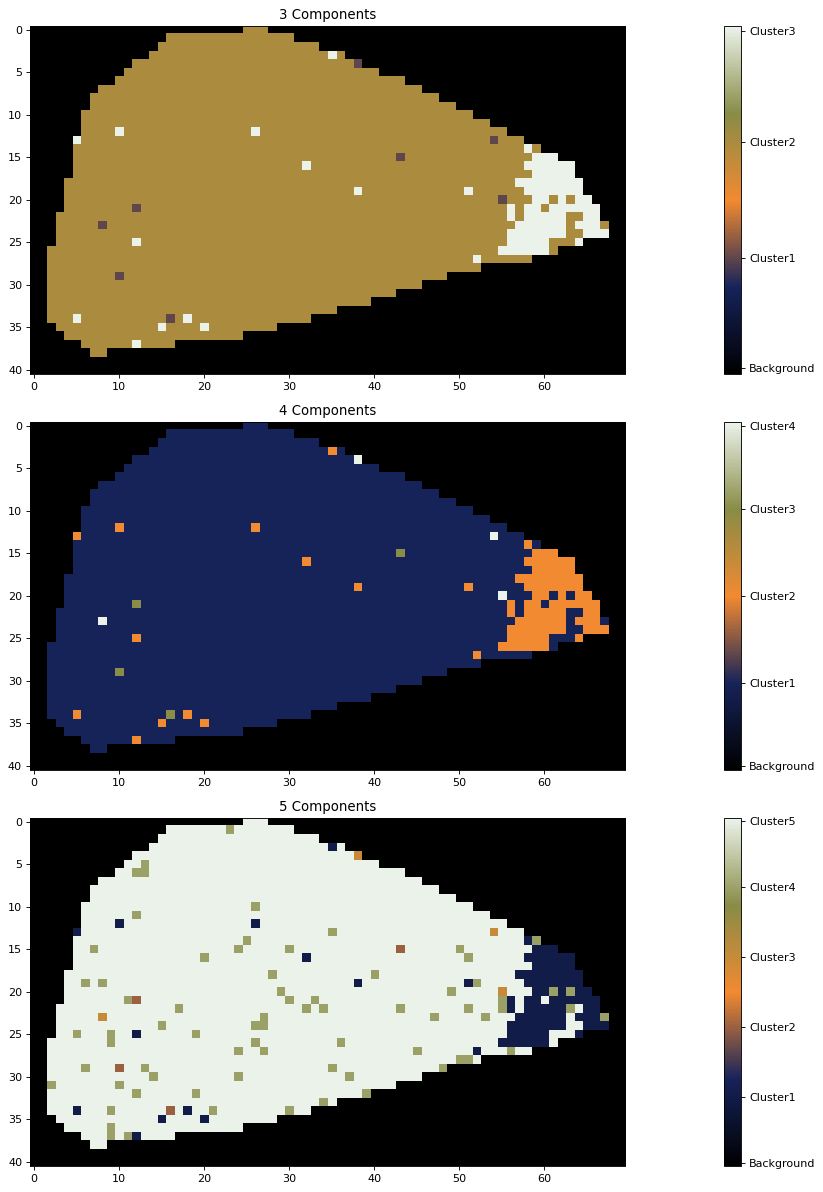

In [34]:
zoomed_height_max , zoomed_height_min , zoomed_width_max , zoomed_width_min = SampleZoomIn(SampleID = 13 , PixelSampleID = pixel_to_sample_ID , padding_factor = 2)

zoomedIn_image_3 = bisecting_kmeans_image_3[zoomed_height_min : zoomed_height_max+1, zoomed_width_min : zoomed_width_max+1]
zoomedIn_image_4 = bisecting_kmeans_image_4[zoomed_height_min : zoomed_height_max+1, zoomed_width_min : zoomed_width_max+1]
zoomedIn_image_5 = bisecting_kmeans_image_5[zoomed_height_min : zoomed_height_max+1, zoomed_width_min : zoomed_width_max+1]

plt.figure(figsize=(25, 15), dpi=80)
plt.figure(1)
plt.subplot(311)
plt.title("3 Components")
plt.imshow(zoomedIn_image_3, cmap=cmap)
colorbar = plt.colorbar()
colorbar.set_ticks([-0.95 , 0 , 1, 1.95])
colorbar.set_ticklabels(["Background" , "Cluster1" , "Cluster2" , "Cluster3"])

plt.subplot(312)
plt.title("4 Components")
plt.imshow(zoomedIn_image_4, cmap=cmap)
colorbar = plt.colorbar()
colorbar.set_ticks([-0.95 , 0 , 1, 2,2.95])
colorbar.set_ticklabels(["Background" , "Cluster1" , "Cluster2" , "Cluster3" , "Cluster4"])

plt.subplot(313)
plt.title("5 Components")
plt.imshow(zoomedIn_image_5, cmap=cmap)
colorbar = plt.colorbar()
colorbar.set_ticks([-0.95 , 0 , 1, 2 , 3 , 3.95])
colorbar.set_ticklabels(["Background" , "Cluster1" , "Cluster2" , "Cluster3","Cluster4","Cluster5"])

plt.tight_layout()
plt.show()

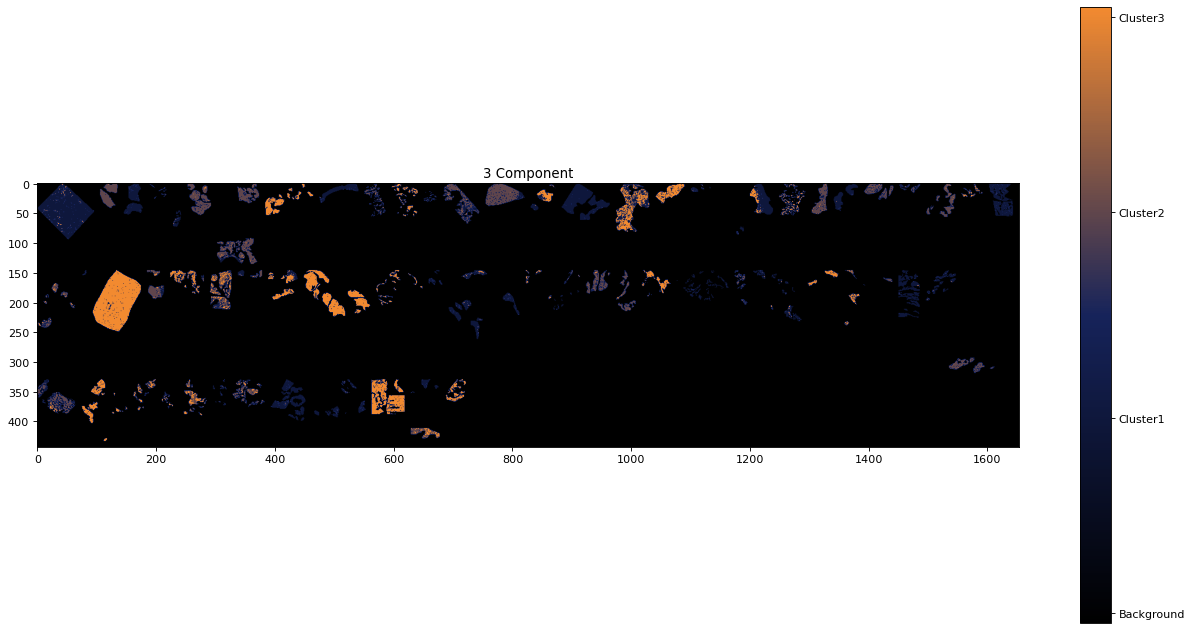

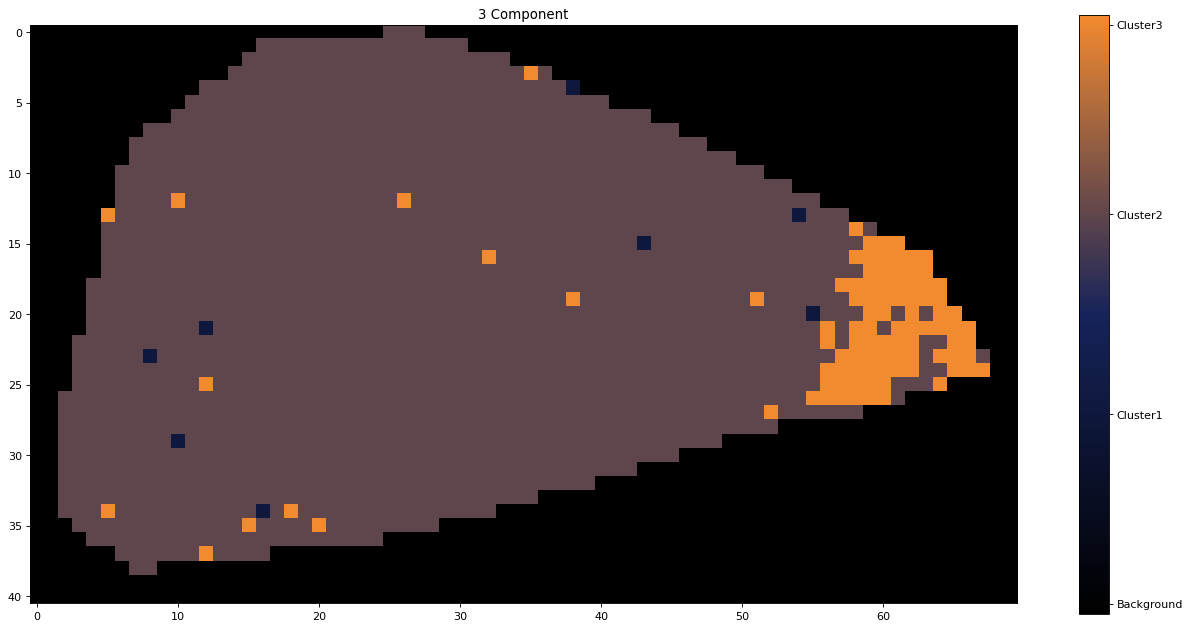

In [35]:
# 3 Components

colors = ["black","#16235A","#F28A30","#888C46"]
cmap = CreateColorMap(NumberofColors = 4 , colorsArray = colors )

plt.figure(figsize=(16, 8), dpi=80)
plt.title("3 Component")
plt.imshow(KMeans_image_3, cmap=cmap)

colorbar = plt.colorbar()
colorbar.set_ticks([-0.95 , 0 , 1, 1.95])
colorbar.set_ticklabels(["Background" , "Cluster1" , "Cluster2" , "Cluster3"])

plt.tight_layout()

# Zooming on sample id 13
SampleZoomIn(SampleID = 13 , PixelSampleID = pixel_to_sample_ID , padding_factor = 2)
bisectingkmeans_zoomedIn_image = bisecting_kmeans_image_3[zoomed_height_min : zoomed_height_max+1, zoomed_width_min : zoomed_width_max+1]

plt.figure(figsize=(16, 8), dpi=80)
plt.imshow(bisectingkmeans_zoomedIn_image,cmap=cmap)
colorbar = plt.colorbar()
colorbar.set_ticks([-0.95 , 0 , 1, 1.95])
colorbar.set_ticklabels(["Background" , "Cluster1" , "Cluster2" , "Cluster3"])
plt.title("3 Component")
plt.tight_layout()


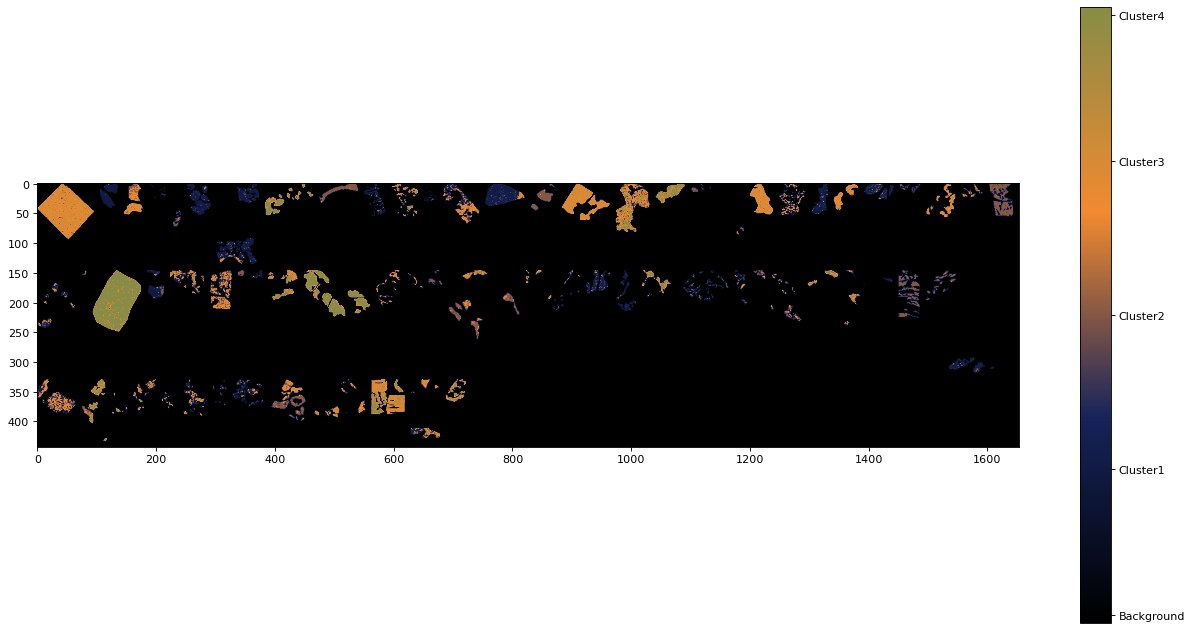

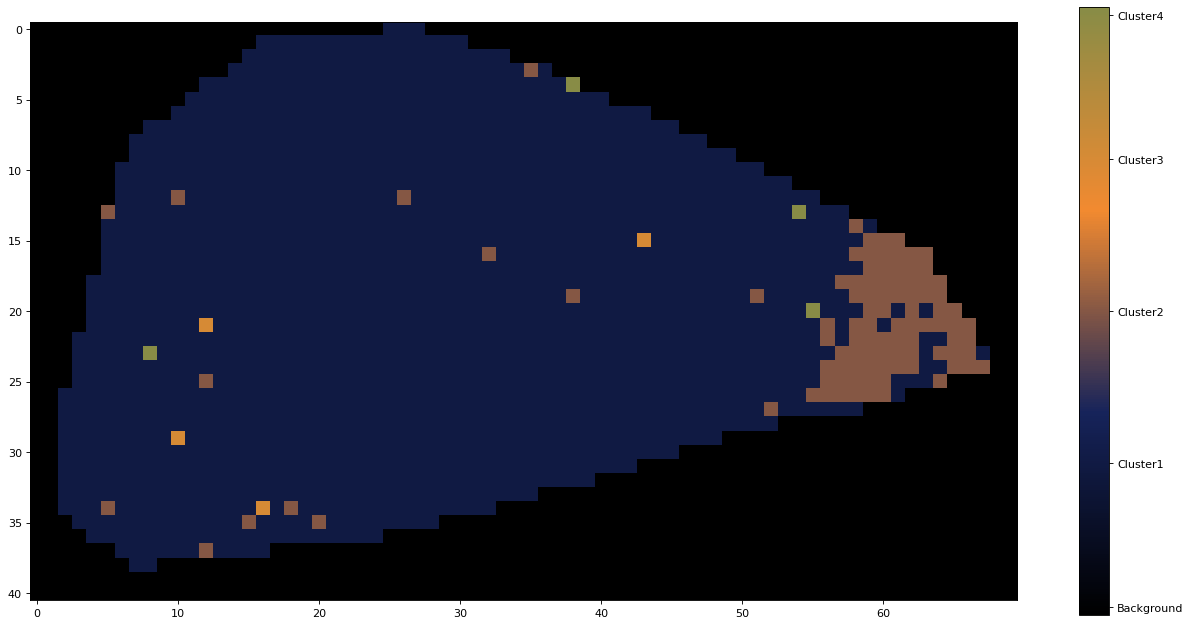

In [36]:
# 4 Components Bisecting Kmeans
# Coloring the K-means image with specific chosen colors)

colors = ["black","#16235A","#F28A30","#888C46", "#EBF2EA"]
cmap = CreateColorMap(NumberofColors = 5 , colorsArray = colors )

plt.figure(figsize=(16, 8), dpi=80)
plt.imshow(KMeans_image_4, cmap=cmap)

colorbar = plt.colorbar()
colorbar.set_ticks([-0.95 , 0 , 1, 2,2.95])
colorbar.set_ticklabels(["Background" , "Cluster1" , "Cluster2" , "Cluster3" , "Cluster4"])

plt.tight_layout()
# Zooming on sample id 13

zoomed_height_max , zoomed_height_min , zoomed_width_max , zoomed_width_min = SampleZoomIn(SampleID = 13 , PixelSampleID = pixel_to_sample_ID , padding_factor = 2)
bisectingkmeans_zoomedIn_image = bisecting_kmeans_image_4[zoomed_height_min : zoomed_height_max+1, zoomed_width_min : zoomed_width_max+1]

plt.figure(figsize=(16, 8), dpi=80)
plt.imshow(bisectingkmeans_zoomedIn_image,cmap=cmap)
colorbar = plt.colorbar()
colorbar.set_ticks([-0.95 , 0 , 1, 2,2.95])
colorbar.set_ticklabels(["Background" , "Cluster1" , "Cluster2" , "Cluster3" , "Cluster4"])

plt.tight_layout()


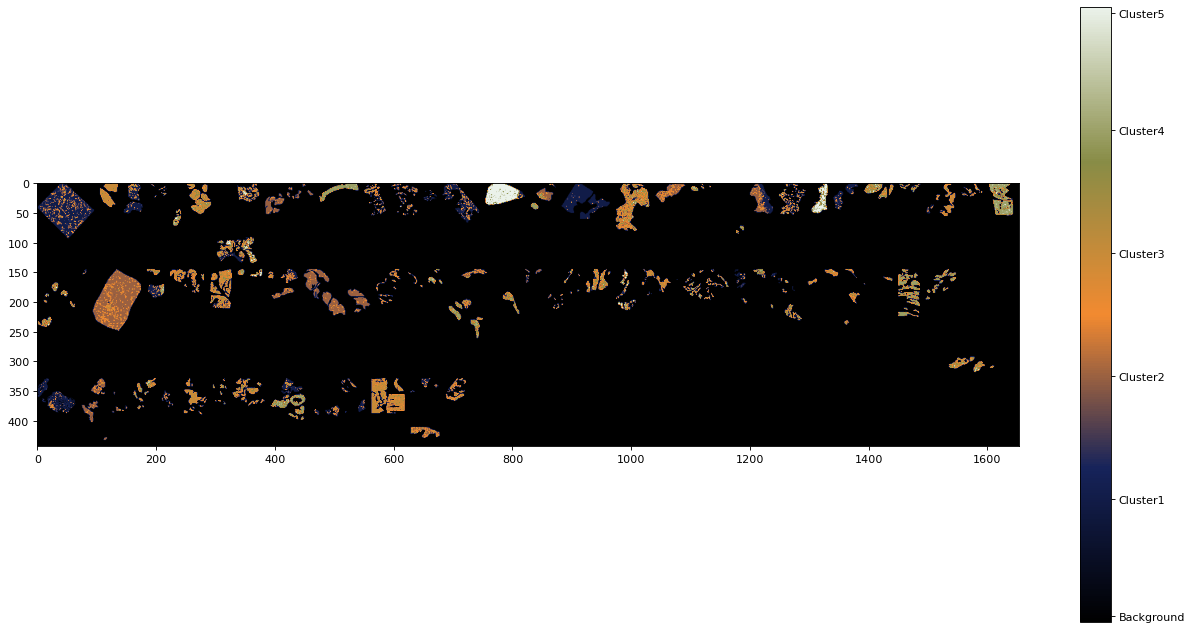

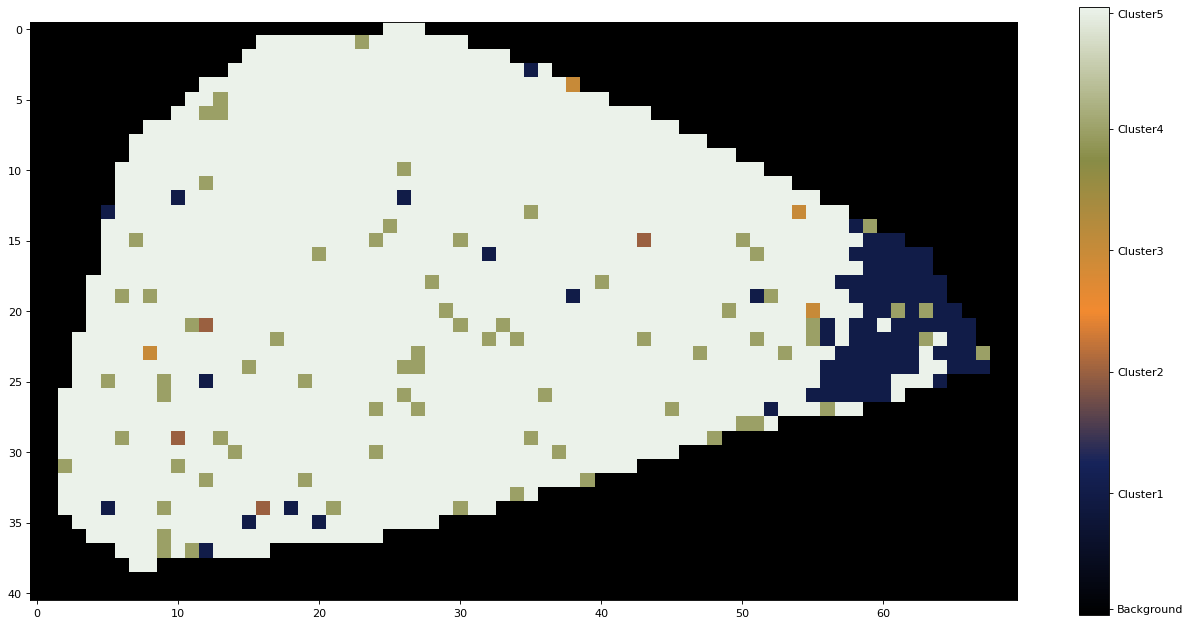

In [37]:
# 5 Components Kmeans

# Coloring the K-means image with specific chosen colors)

colors = ["black","#16235A","#F28A30","#888C46", "#EBF2EA","#0ABDA0"] #PURPLE, #DARK BLUE, #
cmap = CreateColorMap(NumberofColors = 6 , colorsArray = colors)


plt.figure(figsize=(16, 8), dpi=80)
plt.imshow(bisecting_kmeans_image_5, cmap=cmap)

colorbar = plt.colorbar()
colorbar.set_ticks([-0.95 , 0 , 1, 2 , 3 , 3.95])
colorbar.set_ticklabels(["Background" , "Cluster1" , "Cluster2" , "Cluster3","Cluster4","Cluster5"])

plt.tight_layout()

# Zooming on sample id 13
zoomed_height_max , zoomed_height_min , zoomed_width_max , zoomed_width_min = SampleZoomIn(SampleID = 13 , PixelSampleID = pixel_to_sample_ID , padding_factor = 2)
bisectingkmeans_zoomedIn_image = bisecting_kmeans_image_5[zoomed_height_min : zoomed_height_max+1, zoomed_width_min : zoomed_width_max+1]

plt.figure(figsize=(16, 8), dpi=80)
plt.imshow(bisectingkmeans_zoomedIn_image,cmap=cmap)
colorbar = plt.colorbar()
colorbar.set_ticks([-0.95 , 0 , 1, 2 , 3 , 3.95])
colorbar.set_ticklabels(["Background" , "Cluster1" , "Cluster2" , "Cluster3","Cluster4","Cluster5"])

plt.tight_layout()


## Section 6 - Gaussian Mixture


In [38]:
# Gaussian Mixture Model - Run Once

'''

gmm = GaussianMixture(n_components=3, 
                         max_iter=500, 
                         n_init=10, 
                      covariance_type='diag', verbose=0, random_state=42).fit_predict(op_tsne_results)

gmm_4 = GaussianMixture(n_components=4, 
                         max_iter=500, 
                         n_init=10, 
                      covariance_type='diag', verbose=0, random_state=42).fit_predict(op_tsne_results)

gmm_5 = GaussianMixture(n_components=5, 
max_iter=500, 
n_init=10, 
covariance_type='diag', verbose=0, random_state=42).fit_predict(op_tsne_results)

'''



"\n\ngmm = GaussianMixture(n_components=3, \n                         max_iter=500, \n                         n_init=10, \n                      covariance_type='diag', verbose=0, random_state=42).fit_predict(op_tsne_results)\n\ngmm_4 = GaussianMixture(n_components=4, \n                         max_iter=500, \n                         n_init=10, \n                      covariance_type='diag', verbose=0, random_state=42).fit_predict(op_tsne_results)\n\ngmm_5 = GaussianMixture(n_components=5, \nmax_iter=500, \nn_init=10, \ncovariance_type='diag', verbose=0, random_state=42).fit_predict(op_tsne_results)\n\n"

In [108]:
gmm_3 = np.load("gmm_3.npy")
gmm_4 = np.load("gmm_4.npy")
gmm_5 = np.load("gmm_5.npy")

In [40]:
indices_edit = np.where(pixel_to_sample_ID != -1)
gaussian_image_3 = np.full( (height,width),-1 )
gaussian_image_4 = np.full( (height,width),-1 )
gaussian_image_5 = np.full( (height,width),-1 )
increment = 0
for i,j in zip(indices_edit[0],indices_edit[1]):
    gaussian_image_3[i][j] = gmm_3[increment]
    gaussian_image_4[i][j] = gmm_4[increment]
    gaussian_image_5[i][j] = gmm_5[increment]

    increment += 1

In [41]:
colors = ["black","#16235A","#F28A30","#888C46", "#EBF2EA","#0ABDA0"] #PURPLE, #DARK BLUE
cmap = CreateColorMap(NumberofColors = 6 , colorsArray = colors)

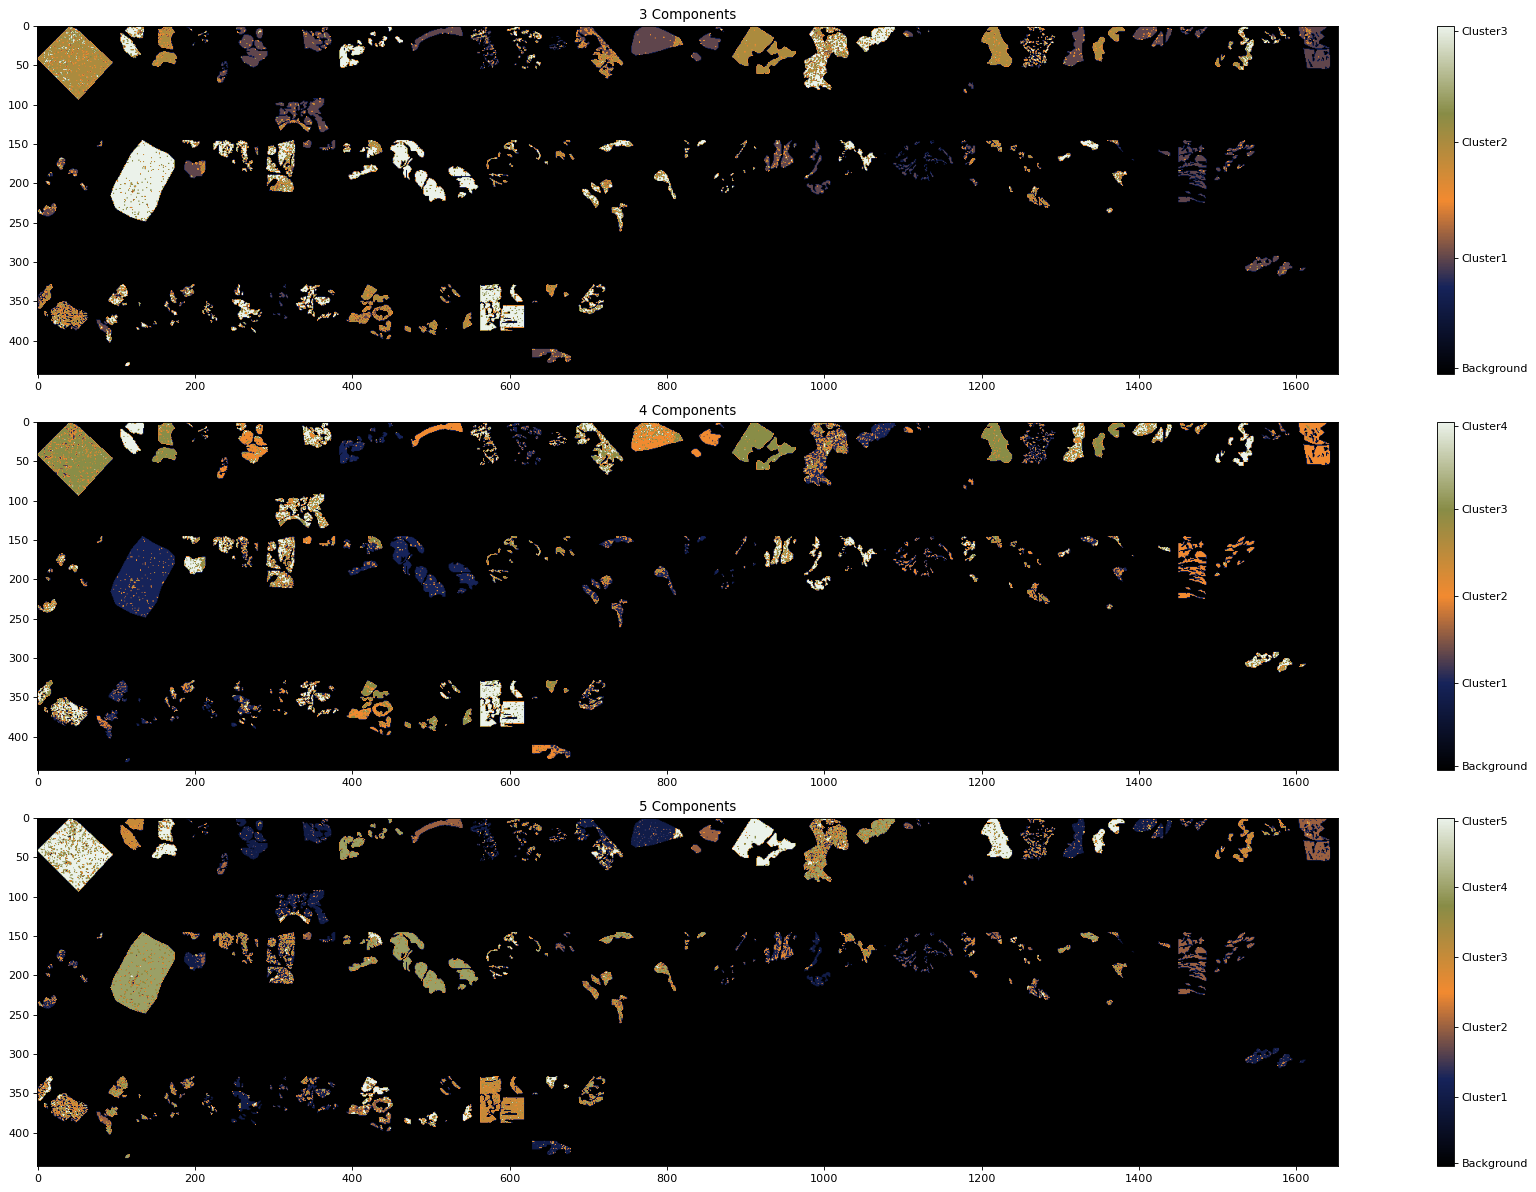

In [42]:
plt.figure(figsize=(25, 15), dpi=80)
plt.figure(1)
plt.subplot(311)
plt.title("3 Components")
plt.imshow(gaussian_image_3, cmap=cmap)
colorbar = plt.colorbar()
colorbar.set_ticks([-0.95 , 0 , 1, 1.95])
colorbar.set_ticklabels(["Background" , "Cluster1" , "Cluster2" , "Cluster3"])

plt.subplot(312)
plt.title("4 Components")
plt.imshow(gaussian_image_4, cmap=cmap)
colorbar = plt.colorbar()
colorbar.set_ticks([-0.95 , 0 , 1, 2,2.95])
colorbar.set_ticklabels(["Background" , "Cluster1" , "Cluster2" , "Cluster3" , "Cluster4"])


plt.subplot(313)
plt.title("5 Components")
plt.imshow(gaussian_image_5, cmap=cmap)
colorbar = plt.colorbar()
colorbar.set_ticks([-0.95 , 0 , 1, 2 , 3 , 3.95])
colorbar.set_ticklabels(["Background" , "Cluster1" , "Cluster2" , "Cluster3","Cluster4","Cluster5"])

plt.tight_layout()
plt.show()


In [43]:
zoomed_height_max , zoomed_height_min , zoomed_width_max , zoomed_width_min = SampleZoomIn(SampleID = 13 , PixelSampleID = pixel_to_sample_ID , padding_factor = 2)

zoomedIn_image_3 = gaussian_image_3[zoomed_height_min : zoomed_height_max+1, zoomed_width_min : zoomed_width_max+1]
zoomedIn_image_4 = gaussian_image_4[zoomed_height_min : zoomed_height_max+1, zoomed_width_min : zoomed_width_max+1]
zoomedIn_image_5 = gaussian_image_5[zoomed_height_min : zoomed_height_max+1, zoomed_width_min : zoomed_width_max+1]


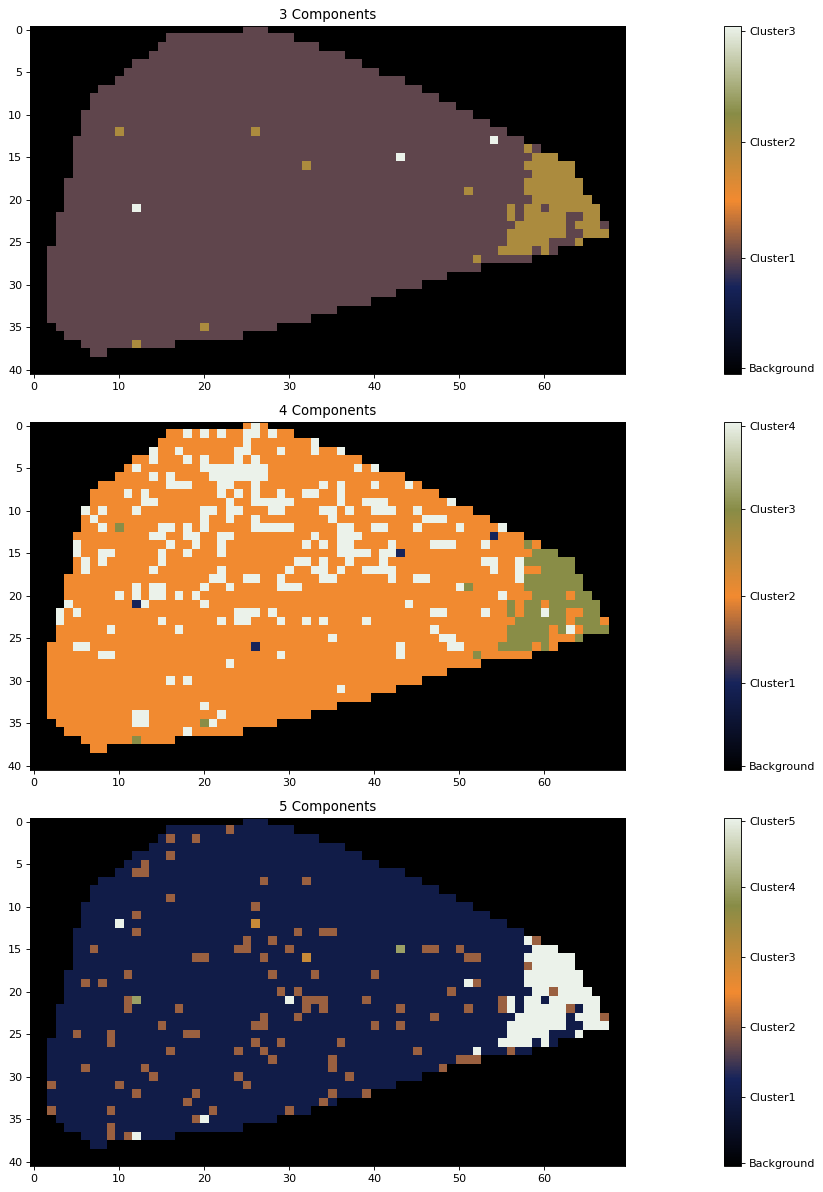

In [44]:
plt.figure(figsize=(25, 15), dpi=80)
plt.figure(1)
plt.subplot(311)
plt.title("3 Components")
plt.imshow(zoomedIn_image_3, cmap=cmap)
colorbar = plt.colorbar()
colorbar.set_ticks([-0.95 , 0 , 1, 1.95])
colorbar.set_ticklabels(["Background" , "Cluster1" , "Cluster2" , "Cluster3"])

plt.subplot(312)
plt.title("4 Components")
plt.imshow(zoomedIn_image_4, cmap=cmap)
colorbar = plt.colorbar()
colorbar.set_ticks([-0.95 , 0 , 1, 2,2.95])
colorbar.set_ticklabels(["Background" , "Cluster1" , "Cluster2" , "Cluster3" , "Cluster4"])

plt.subplot(313)
plt.title("5 Components")
plt.imshow(zoomedIn_image_5, cmap=cmap)
colorbar = plt.colorbar()
colorbar.set_ticks([-0.95 , 0 , 1, 2 , 3 , 3.95])
colorbar.set_ticklabels(["Background" , "Cluster1" , "Cluster2" , "Cluster3","Cluster4","Cluster5"])

plt.tight_layout()
plt.show()

In [45]:
'''
model3= GaussianMixture(n_components=3, # this is the number of clusters
                         covariance_type='diag', # {‘full’, ‘tied’, ‘diag’, ‘spherical’}, default=’full’
                         max_iter=100, # the number of EM iterations to perform. default=100
                         n_init=1, # the number of initializations to perform. default = 1
                         init_params='kmeans', # the method used to initialize the weights, the means and the precisions. {'random' or default='k-means'}
                         verbose=0, # default 0, {0,1,2}
                         random_state=1 # for reproducibility
                        )

# Fit the model and predict labels
clust3 = model3.fit(op_tsne_results)
labels3 = model3.predict(op_tsne_results)

# Generate 10,000 new samples based on the model
smpl=model3.sample(n_samples=10000)

# Print model summary
print('*************** 3 Cluster Model ***************')
#print('Weights: ', clust3.weights_)
print('Means: ', clust3.means_)
#print('Covariances: ', clust3.covariances_)
#print('Precisions: ', clust3.precisions_)
#print('Precisions Cholesky: ', clust3.precisions_cholesky_)
print('Converged: ', clust3.converged_)
print(' No. of Iterations: ', clust3.n_iter_)
#print('Lower Bound: ', clust3.lower_bound_)

'''

"\nmodel3= GaussianMixture(n_components=3, # this is the number of clusters\n                         covariance_type='diag', # {‘full’, ‘tied’, ‘diag’, ‘spherical’}, default=’full’\n                         max_iter=100, # the number of EM iterations to perform. default=100\n                         n_init=1, # the number of initializations to perform. default = 1\n                         init_params='kmeans', # the method used to initialize the weights, the means and the precisions. {'random' or default='k-means'}\n                         verbose=0, # default 0, {0,1,2}\n                         random_state=1 # for reproducibility\n                        )\n\n# Fit the model and predict labels\nclust3 = model3.fit(op_tsne_results)\nlabels3 = model3.predict(op_tsne_results)\n\n# Generate 10,000 new samples based on the model\nsmpl=model3.sample(n_samples=10000)\n\n# Print model summary\nprint('*************** 3 Cluster Model ***************')\n#print('Weights: ', clust3.weights_)\

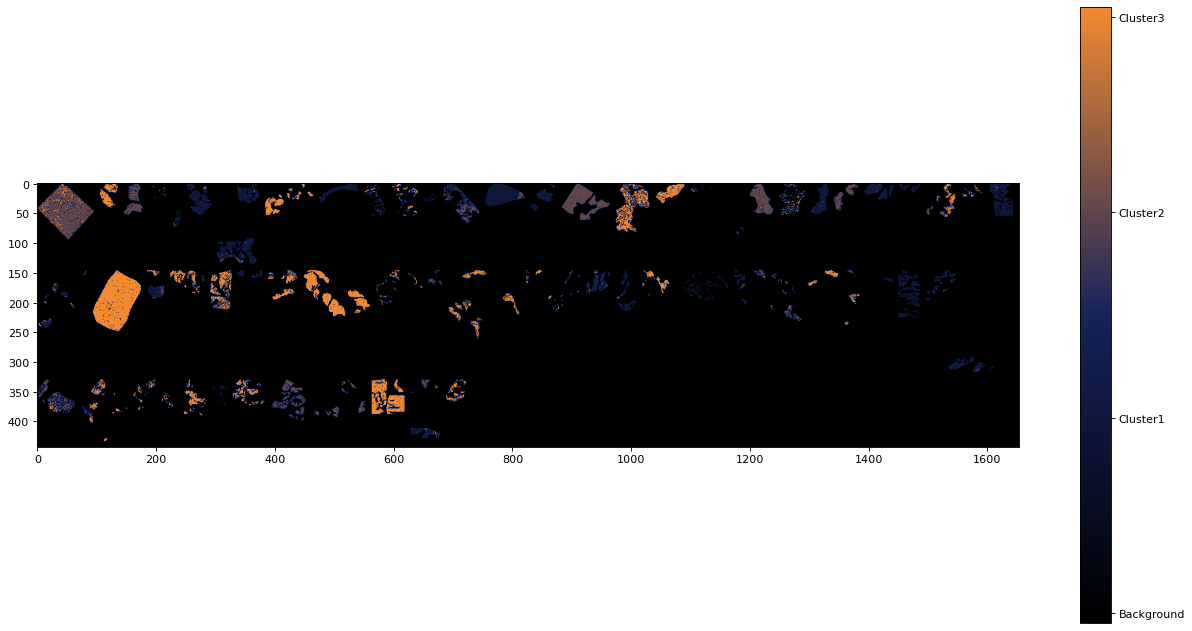

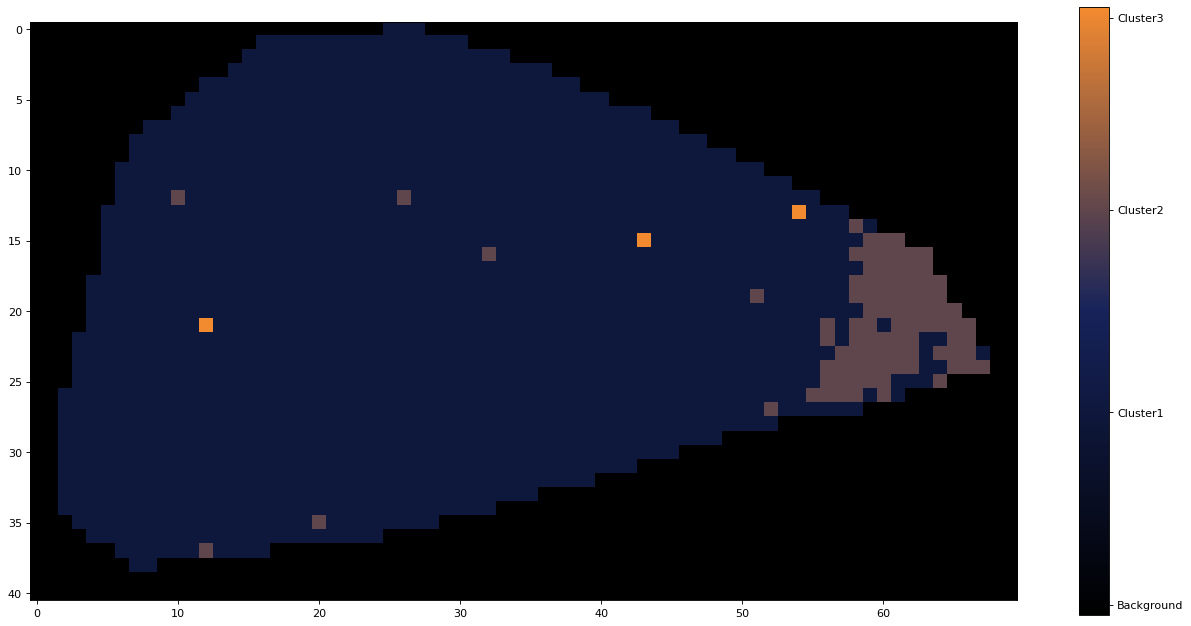

In [46]:
# 3 Components Gaussian

# Coloring the Gaussian image with specific chosen colors

cvals = [0, 1, 2,3]
colors = ["black","#16235A","#F28A30","#888C46"]
cmap = CreateColorMap(NumberofColors = 4 , colorsArray = colors)

plt.figure(figsize=(16, 8), dpi=80)
plt.imshow(gaussian_image_3, cmap=cmap)

colorbar = plt.colorbar()
colorbar.set_ticks([-0.95 , 0 , 1, 1.95])
colorbar.set_ticklabels(["Background" , "Cluster1" , "Cluster2" , "Cluster3"])

plt.tight_layout()
# Zooming on sample id 13

zoomed_height_max , zoomed_height_min , zoomed_width_max , zoomed_width_min = SampleZoomIn(SampleID = 13 , PixelSampleID = pixel_to_sample_ID , padding_factor = 2)
Gaussian_ZoomedInImage = gaussian_image_3[zoomed_height_min : zoomed_height_max+1, zoomed_width_min : zoomed_width_max+1]
plt.figure(figsize=(16, 8), dpi=80)
plt.imshow(Gaussian_ZoomedInImage,cmap=cmap)
colorbar = plt.colorbar()
colorbar.set_ticks([-0.95 , 0 , 1, 1.95])
colorbar.set_ticklabels(["Background" , "Cluster1" , "Cluster2" , "Cluster3"])

plt.tight_layout()


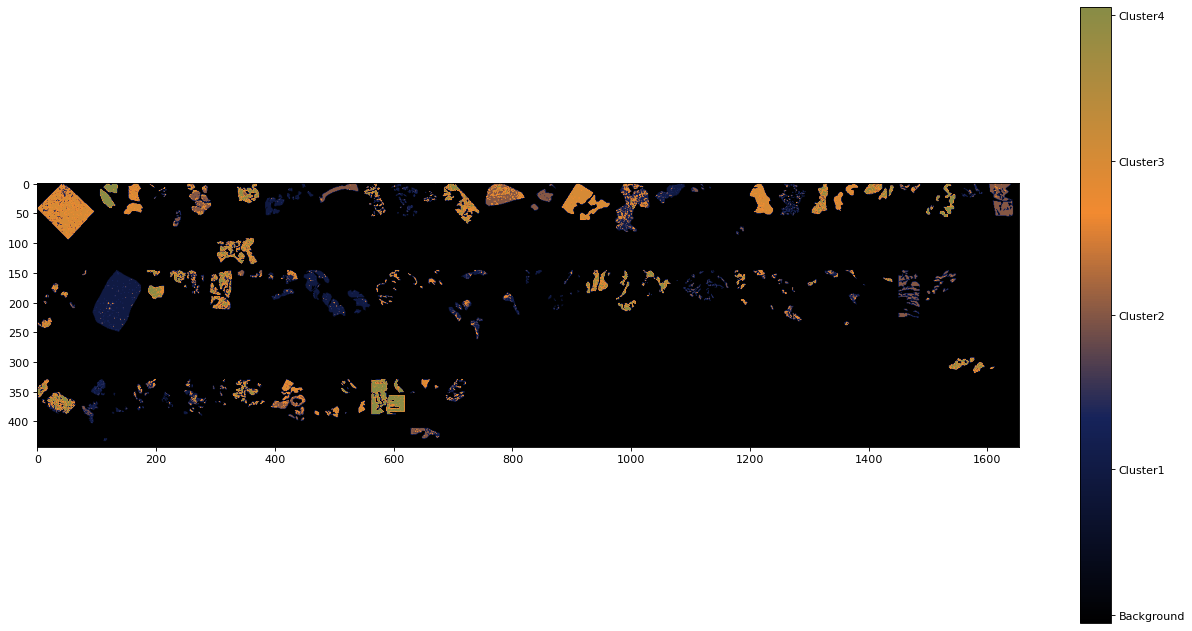

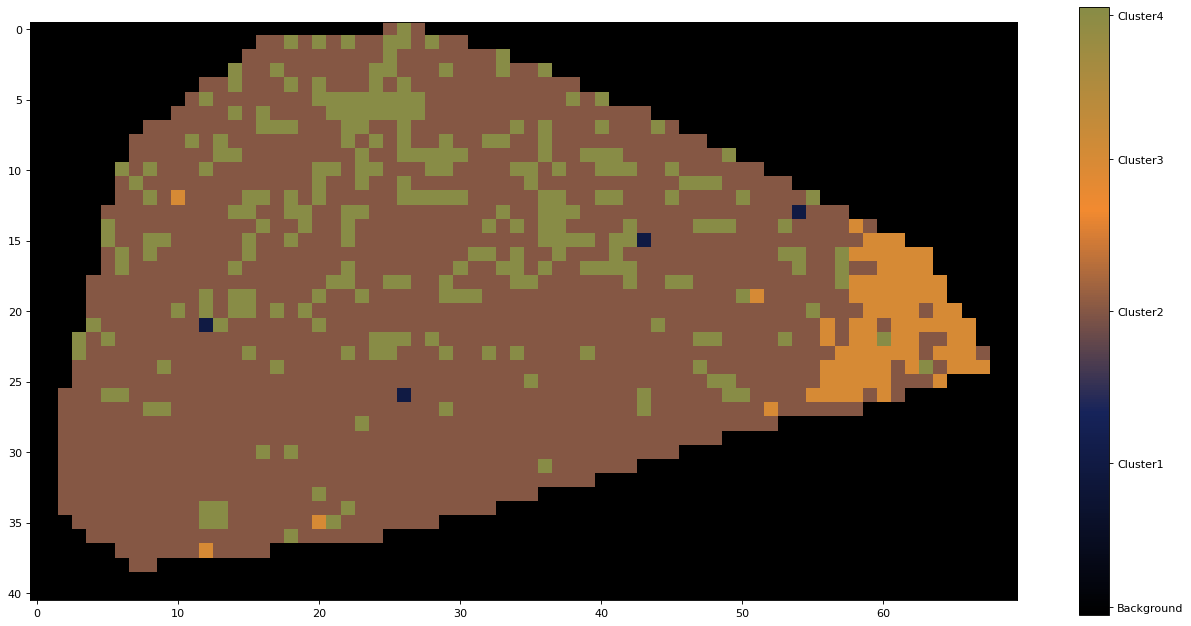

In [47]:
# 4 Components Gaussian

# Coloring the Gaussian image with specific chosen colors)

cvals = [0, 1, 2,3,4]
colors = ["black","#16235A","#F28A30","#888C46", "#EBF2EA"]
cmap = CreateColorMap(NumberofColors=5 , colorsArray = colors)

plt.figure(figsize=(16, 8), dpi=80)
plt.imshow(gaussian_image_4, cmap=cmap)

colorbar = plt.colorbar()
colorbar.set_ticks([-0.95 , 0 , 1, 2,2.95])
colorbar.set_ticklabels(["Background" , "Cluster1" , "Cluster2" , "Cluster3" , "Cluster4"])

plt.tight_layout()
# Zooming on sample id 13

zoomed_height_max , zoomed_height_min , zoomed_width_max , zoomed_width_min = SampleZoomIn(SampleID = 13 , PixelSampleID = pixel_to_sample_ID , padding_factor = 2)
Gaussian_ZoomedInImage = gaussian_image_4[zoomed_height_min : zoomed_height_max+1, zoomed_width_min : zoomed_width_max+1]

plt.figure(figsize=(16, 8), dpi=80)
plt.imshow(Gaussian_ZoomedInImage,cmap=cmap)
colorbar = plt.colorbar()
colorbar.set_ticks([-0.95 , 0 , 1, 2,2.95])
colorbar.set_ticklabels(["Background" , "Cluster1" , "Cluster2" , "Cluster3" , "Cluster4"])

plt.tight_layout()


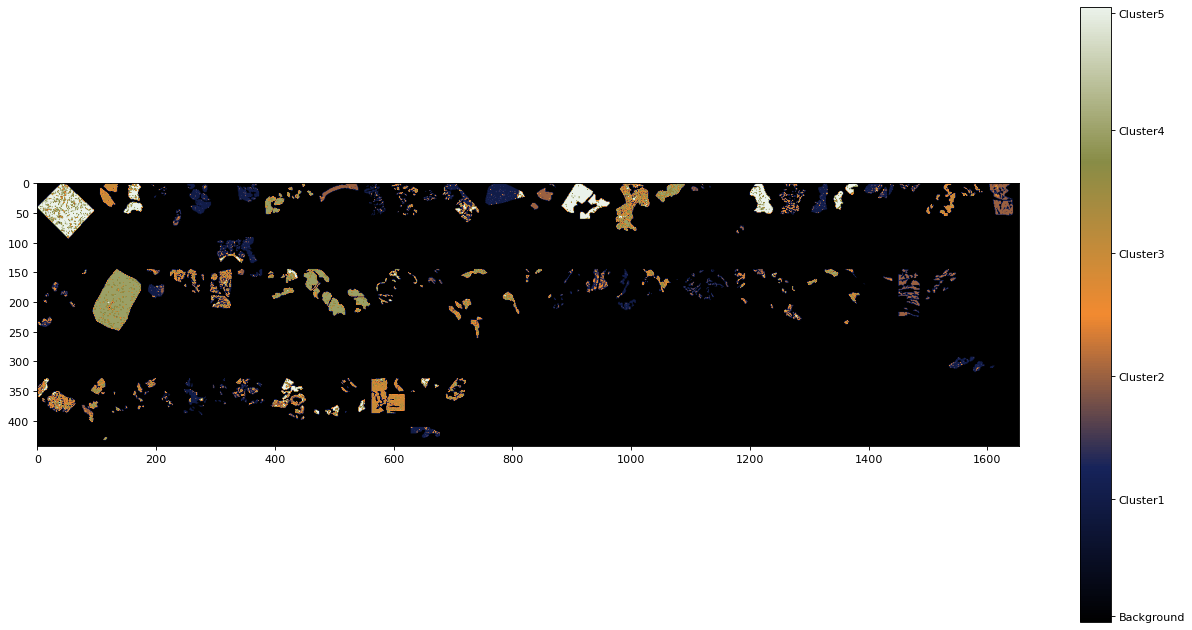

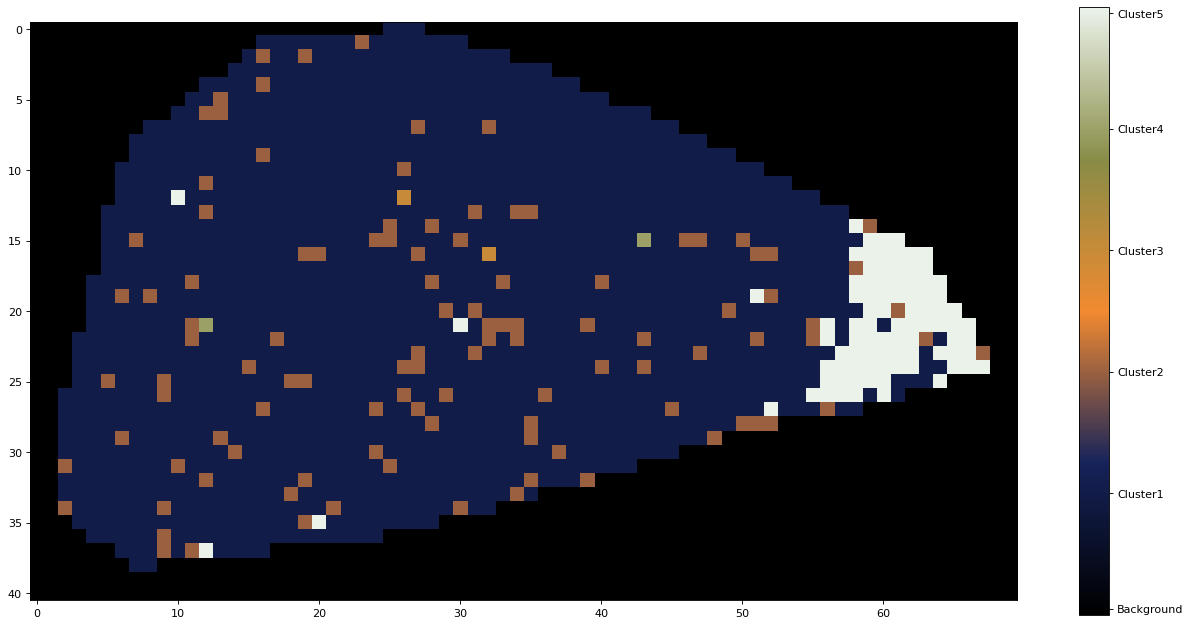

In [48]:
# 5 Components

# Coloring the Gaussian image with specific colors

cvals = [0, 1, 2,3,4,5]
colors = ["black","#16235A","#F28A30","#888C46", "#EBF2EA","#0ABDA0"] #PURPLE, #DARK BLUE, #
cmap = CreateColorMap(NumberofColors=6 , colorsArray=colors)

plt.figure(figsize=(16, 8), dpi=80)
plt.imshow(gaussian_image_5, cmap=cmap)

colorbar = plt.colorbar()
colorbar.set_ticks([-0.95 , 0 , 1, 2 , 3 , 3.95])
colorbar.set_ticklabels(["Background" , "Cluster1" , "Cluster2" , "Cluster3","Cluster4","Cluster5"])

plt.tight_layout()
# Zooming on sample id 13
zoomed_height_max , zoomed_height_min , zoomed_width_max , zoomed_width_min = SampleZoomIn(SampleID = 13 , PixelSampleID = pixel_to_sample_ID , padding_factor = 2)
Gaussian_ZoomedInImage = gaussian_image_5[zoomed_height_min : zoomed_height_max+1, zoomed_width_min : zoomed_width_max+1]

plt.figure(figsize=(16, 8), dpi=80)
plt.imshow(Gaussian_ZoomedInImage,cmap=cmap)
colorbar = plt.colorbar()
colorbar.set_ticks([-0.95 , 0 , 1, 2 , 3 , 3.95])
colorbar.set_ticklabels(["Background" , "Cluster1" , "Cluster2" , "Cluster3","Cluster4","Cluster5"])

plt.tight_layout()


## Section 7 - Survival Rate/Kaplan Meier

In [54]:
Clinical_data = pd.read_excel('ClinicalData.xlsx')

In [123]:
Cluster_1=[]  # Clusters in each patient sample
Cluster_2=[]
Cluster_3=[]

for i in range(1,len(Clinical_data) +1):
    Pixels_Samples= np.where(sample_ID_pixels == i )[0]
    Patient_Labels= bisecting_kmeans_labels_3[Pixels_Samples]
    Patient_Pixels = Patient_Labels[Patient_Labels == 0]

    if len(Patient_Pixels) > 1/3 * len(Patient_Labels):
        Cluster_1.append(i)

    Patient_Pixels = Patient_Labels[Patient_Labels == 1]

    if len(Patient_Pixels) > 1/3 * len(Patient_Labels):
        Cluster_2.append(i)

    Patient_Pixels = Patient_Labels[Patient_Labels == 2]

    if len(Patient_Pixels) > 1/3 * len(Patient_Labels):
        Cluster_3.append(i)

print(Cluster_1)
print(Cluster_2)
print(Cluster_3)


[2, 5, 7, 9, 10, 11, 14, 16, 17, 19, 20, 23, 25, 26, 29, 31, 32, 35, 36, 37, 40, 41, 42, 43, 45, 49, 50, 52, 54, 55, 56, 58, 60, 61, 62, 63]
[4, 8, 13, 14, 18, 20, 21, 24, 26, 27, 28, 33, 34, 38, 39, 42, 44, 46, 48, 51, 52, 55, 57, 59]
[1, 3, 6, 11, 12, 15, 19, 22, 24, 30, 44, 47, 53, 59, 60]


In [124]:
Clinical_data

Sample_ID  T  N    M  Surv_time  Surv_status  Belong_Cluster_1  \
0           1  2  0  'x'       1027            0                 0   
1           2  2  0  'x'         20            1                 0   
2           3  2  0  'x'         13            0                 0   
3           4  2  0  'x'       1350            0                 1   
4           5  2  0  'x'       1006            1                 1   
..        ... .. ..  ...        ...          ...               ...   
58         59  2  1  'x'        623            1                 0   
59         60  2  2  '1'          9            1                 0   
60         61  2  3  'x'         80            1                 0   
61         62  2  3  'x'         14            1                 1   
62         63  2  3  'x'         34            1                 0   

    Belong_Cluster_2  Belong_Cluster_3  
0                  1                 0  
1                  0                 1  
2                  1                 0  
3                  0                 0  
4                  0                 0  
..               ...               ...  
58                 1                 0  
59                 1                 0  
60                 0                 1  
61                 0                 0  
62                 0                 1  

[63 rows x 9 columns]

In [125]:
Belong_Cluster_1=[]
Belong_Cluster_2=[]
Belong_Cluster_3=[]

for i in range(1, len(Clinical_data)+1):
    if(i in Cluster_1):
        Belong_Cluster_1.append(1)
    else:
        Belong_Cluster_1.append(0)

    if(i in Cluster_2):
        Belong_Cluster_2.append(1)
    else:
        Belong_Cluster_2.append(0)

    if(i in Cluster_3):
        Belong_Cluster_3.append(1)
    else:
        Belong_Cluster_3.append(0)
    



In [126]:
Clinical_data["Belong_Cluster_1"]= Belong_Cluster_1
Clinical_data["Belong_Cluster_2"]= Belong_Cluster_2
Clinical_data["Belong_Cluster_3"]= Belong_Cluster_3

In [127]:
Clinical_data

Sample_ID  T  N    M  Surv_time  Surv_status  Belong_Cluster_1  \
0           1  2  0  'x'       1027            0                 0   
1           2  2  0  'x'         20            1                 1   
2           3  2  0  'x'         13            0                 0   
3           4  2  0  'x'       1350            0                 0   
4           5  2  0  'x'       1006            1                 1   
..        ... .. ..  ...        ...          ...               ...   
58         59  2  1  'x'        623            1                 0   
59         60  2  2  '1'          9            1                 1   
60         61  2  3  'x'         80            1                 1   
61         62  2  3  'x'         14            1                 1   
62         63  2  3  'x'         34            1                 1   

    Belong_Cluster_2  Belong_Cluster_3  
0                  0                 1  
1                  0                 0  
2                  0                 1  
3                  1                 0  
4                  0                 0  
..               ...               ...  
58                 1                 1  
59                 0                 1  
60                 0                 0  
61                 0                 0  
62                 0                 0  

[63 rows x 9 columns]

In [128]:
Cluster_1_Data=Clinical_data.loc[Clinical_data['Belong_Cluster_1'] == 1] # Cluster 1 in all samples
Cluster_2_Data=Clinical_data.loc[Clinical_data['Belong_Cluster_2'] == 1] # Cluster 1 in all samples
Cluster_3_Data=Clinical_data.loc[Clinical_data['Belong_Cluster_3'] == 1] # Cluster 1 in all samples

In [129]:
Cluster_1_Data

Sample_ID  T  N    M  Surv_time  Surv_status  Belong_Cluster_1  \
1           2  2  0  'x'         20            1                 1   
4           5  2  0  'x'       1006            1                 1   
6           7  2  0  'x'         47            0                 1   
8           9  2  0  'x'       1341            0                 1   
9          10  2  0  'x'       1558            0                 1   
10         11  2  0  'x'       1625            0                 1   
13         14  2  0  'x'         25            1                 1   
15         16  2  0  'x'        238            1                 1   
16         17  2  0  'x'       1163            0                 1   
18         19  2  1  'x'        472            0                 1   
19         20  2  1  'x'         56            0                 1   
22         23  2  1  'x'         66            0                 1   
24         25  2  1  'x'        175            1                 1   
25         26  2  1  'x'       1062            0                 1   
28         29  2  1  'x'        288            1                 1   
30         31  2  1  'x'        176            0                 1   
31         32  2  1  'x'         10            0                 1   
34         35  2  1  'x'        977            0                 1   
35         36  2  1  '1'        204            0                 1   
36         37  2  1  'x'         21            1                 1   
39         40  2  1  'x'        183            0                 1   
40         41  2  1  'x'        159            0                 1   
41         42  2  1  '1'       1468            1                 1   
42         43  2  2  '1'        172            0                 1   
44         45  2  2  'x'        430            1                 1   
48         49  2  2  'x'         76            1                 1   
49         50  2  2  '1'         26            0                 1   
51         52  2  2  'x'         17            0                 1   
53         54  2  2  'x'         22            0                 1   
54         55  2  2  'x'         28            0                 1   
55         56  2  2  '1'        137            1                 1   
57         58  2  3  'x'          0            0                 1   
59         60  2  2  '1'          9            1                 1   
60         61  2  3  'x'         80            1                 1   
61         62  2  3  'x'         14            1                 1   
62         63  2  3  'x'         34            1                 1   

    Belong_Cluster_2  Belong_Cluster_3  
1                  0                 0  
4                  0                 0  
6                  0                 0  
8                  0                 0  
9                  0                 0  
10                 0                 1  
13                 1                 0  
15                 0                 0  
16                 0                 0  
18                 0                 1  
19                 1                 0  
22                 0                 0  
24                 0                 0  
25                 1                 0  
28                 0                 0  
30                 0                 0  
31                 0                 0  
34                 0                 0  
35                 0                 0  
36                 0                 0  
39                 0                 0  
40                 0                 0  
41                 1                 0  
42                 0                 0  
44                 0                 0  
48                 0                 0  
49                 0                 0  
51                 1                 0  
53                 0                 0  
54                 1                 0  
55                 0                 0  
57                 0                 0  
59                 0                 1  
60                 

In [130]:
Cluster_1_Data['Surv_time'] = Cluster_1_Data['Surv_time'].div(30)
Surv_time_Cluster1=Cluster_1_Data["Surv_time"].to_list()
Surv_status_Cluster1=Cluster_1_Data["Surv_status"].to_list()

Cluster_2_Data['Surv_time'] = Cluster_2_Data['Surv_time'].div(30)
Surv_time_Cluster2=Cluster_2_Data["Surv_time"].to_list()
Surv_status_Cluster2=Cluster_2_Data["Surv_status"].to_list()

Cluster_3_Data['Surv_time'] = Cluster_3_Data['Surv_time'].div(30)
Surv_time_Cluster3=Cluster_3_Data["Surv_time"].to_list()
Surv_status_Cluster3=Cluster_3_Data["Surv_status"].to_list()


# print(Surv_time_Cluster1)

<ipython-input-130-cf12037c337d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cluster_1_Data['Surv_time'] = Cluster_1_Data['Surv_time'].div(30)
<ipython-input-130-cf12037c337d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cluster_2_Data['Surv_time'] = Cluster_2_Data['Surv_time'].div(30)
<ipython-input-130-cf12037c337d>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

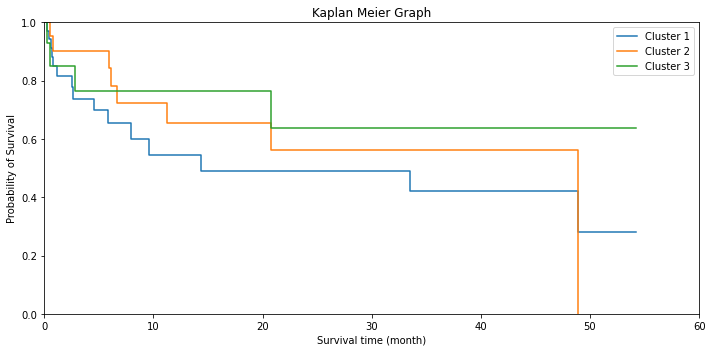

In [131]:
kmf1 = KaplanMeierFitter() ## instantiate the class to create an object

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)

kmf1.fit(Surv_time_Cluster1, Surv_status_Cluster1, label='Cluster 1')
kmf1.plot(ax= ax ,ci_show=False)


kmf1.fit(Surv_time_Cluster2, Surv_status_Cluster2, label='Cluster 2')
kmf1.plot(ax= ax, ci_show=False)


kmf1.fit(Surv_time_Cluster3, Surv_status_Cluster3, label='Cluster 3')
kmf1.plot(ax=ax, ci_show=False)

plt.title("Kaplan Meier Graph")
plt.xlabel('Survival time (month)')
plt.ylabel('Probability of Survival')
plt.ylim([0,1])
plt.xlim([0,60])
plt.tight_layout()

